# 0X_tree_models



In [1]:
import os
import math
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.metrics import accuracy_score

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

import statsmodels.formula.api as sm

# Avoid scientific notation output in Pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '{:,.2f}'.format
import logging

# Improve resolution of output graphcis
%matplotlib inline
%config InlineBackend.figure_format ='retina'

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important;}</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('..')

In [3]:
# !pip install graphviz
# !brew install graphviz
from sklearn import tree
import graphviz

In [4]:
from src.scale import *
from src.model import *
from src.visualize import *
from src.datagen import generate_interval_data

## Get Project Data Based on Interval

In [7]:
file_path_train = '../data/processed/NYC_capital_projects_3yr_final_train.csv'
file_path_test = '../data/processed/NYC_capital_projects_3yr_final_test.csv'
    
if os.path.isfile(file_path_train) and os.path.isfile(file_path_test):
    print("OK - path points to file.")
else:
    print("ERROR - check the 'file_path' and ensure it points to the source file.")

OK - path points to file.


In [6]:
data_ = pd.read_csv(file_path)

In [7]:
data = pd.read_csv(file_path)
data = generate_interval_data(data, change_year_interval=3)

The number of unique projects in the resulting dataframe: 149



## Manually Collapse Categories

In [8]:
print(
    'The original {} project categories and assocated project counts:\n\n'\
    '{}\n\n'.format(
        data['Category'].nunique(),
        data['Category'].value_counts()
    )
)

rename_cat_dict = {
    'Bridges, Streets and Roadways': 'Bridges',
    'Parks, Streets and Roadways': 'Parks',
    'Industrial Development, Parks': 'Industrial Development',
    'Other Government Facilities': 'Other Govt Facilities and Improvements',
    'Public Safety and Criminal Justice': 'Other Govt Facilities and Improvements',
    'Arts and Culture': 'Other Govt Facilities and Improvements',
    'Health and Hospitals': 'Other Govt Facilities and Improvements',
}

data['Category_Old'] = data['Category'].copy()
data['Category'] = data['Category'].copy().map(rename_cat_dict).fillna(data['Category'])

print(
    'The newly mapped {} project categories and project counts:\n\n'\
    '{}\n'.format(
        data['Category'].nunique(),
        data['Category'].value_counts()
    )
)

The original 17 project categories and assocated project counts:

Streets and Roadways                  31
Sewers                                20
Schools                               15
Industrial Development                15
Wastewater Treatment                  13
Water Supply                          13
Bridges, Streets and Roadways          9
Bridges                                7
Sanitation                             6
Other Government Facilities            4
Public Safety and Criminal Justice     4
Health and Hospitals                   3
Ferries                                3
Parks                                  2
Arts and Culture                       2
Parks, Streets and Roadways            1
Industrial Development, Parks          1
Name: Category, dtype: int64


The newly mapped 11 project categories and project counts:

Streets and Roadways                      31
Sewers                                    20
Bridges                                   16
Industrial 

## Select Attributes (X) and Target Values (Y)

In [9]:
# All possible (reasonable) Attributes
X_cols_all = [
    'Category',
    'Borough',
    'Managing_Agency',
    'Client_Agency',
    'Budget_Start',
    'Duration_Start'
]

# includes +/- values of total change
y_cols_change = [
    'Budget_Change',
    'Schedule_Change'
]

# final budget amount and duration
y_cols_end_value = [
    'Budget_End',
    'Duration_End'
]

# includes +/- values of relative change
y_cols_ratio = [
    'Budget_Change_Ratio',
    'Schedule_Change_Ratio'
]


### Define the X and Y Columns

In [10]:
def dummify(df, x_cols, col_names) -> (pd.DataFrame, list):
    
    dummy_cols_dict = {}
    
    for col_name in col_names:
        
        start_cols = df.columns
        df = encode_categories(df, col_name, one_hot=True, drop_cat=None, cat_list=None, drop_original_col=True)

        # get column differences of before and after making dummies
        new_dummy_cols = list(set(df.columns) - set(start_cols))

        # remove the original and replace with one-hot encoded columns
        x_cols.remove(col_name)
        x_cols += new_dummy_cols
        
        # keep a dictionary of changes
        dummy_cols_dict.update({col_name: new_dummy_cols})

    return df, x_cols, dummy_cols_dict

In [11]:
def define_train_and_test(data, dummy_cols, attributes, responses, logistic=True): 
    
    X_cols = attributes.copy() #X_cols_all.copy()

    # define the y column set to use
    y_cols = responses.copy()

    # dummify selected columns
    data_dummies, X_cols, dummies_dict = dummify(data, X_cols, dummy_cols)

    # define the starting X and y datasets
    X, y = data_dummies[X_cols], data_dummies[y_cols]

    # make the y values categorical
    if logistic:
        y = (y>0)*1

    # create train and test sets
    random_state = 109
    test_size = 0.1

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        shuffle=True)
    
    return X_tr, X_te, y_tr, y_te, dummies_dict

In [12]:
# define the x colum set to use
attributes = [  'Category',
                'Borough',
                'Managing_Agency',
                'Client_Agency',
                'Budget_Start',
                'Duration_Start' ]

dummy_columns = ['Category', 'Borough', 'Managing_Agency', 'Client_Agency']

responses = [ 'Budget_Change',
              'Schedule_Change' ]

X_train, X_test, y_train, y_test, dummies_dict = define_train_and_test(data, dummy_columns, attributes, responses, logistic=True)


In [13]:
# double check sizes
print('{}\t{}'.format(X_train.shape, y_train.shape))
print('{}\t{}'.format(X_test.shape, y_test.shape))

(134, 48)	(134, 2)
(15, 48)	(15, 2)


In [14]:
#######################################
# CREATE SCALED DATAFRAMES
#######################################

# Identify columns to exclude from scaling (i.e. binary and non-predictor columns)
exclude_scale_cols = dummy_columns

# Perform standard scaling on both X_train and X_test data, fitting X_train as the
# scaler for both
scaler = StandardScaler
scale_before_func = None
scale_after_func = None

X_train_stdz, Scaler_stdz = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)

X_test_stdz, Scaler_stdz = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)

# Perform standard scaling and then pass through sigmoid transformation
scaler = StandardScaler
scale_before_func = None
scale_after_func = sigmoid

X_train_stdz_sig, _ = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)

X_test_stdz_sig, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)


# Perform normalized scaling on both X_train and X_test data, fitting X_train as the
# scaler for both
scaler = MinMaxScaler
scale_before_func = None
scale_after_func = None

X_train_norm, Scaler_norm = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)

X_test_norm, Scaler_norm = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)


# Perform normalized scaling then add 1 and perform log transformation and renormalize
scaler = MinMaxScaler
scale_before_func = None
scale_after_func = log_plus_one
reapply_scaler = True

X_train_norm_log, _ = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

X_test_norm_log, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)


# Perform 'Robust' scaling on both X_train and X_test data, fitting X_train as the
# scaler for both
scaler = RobustScaler
scale_before_func = None
scale_after_func = None

X_train_rob, Scaler_rob = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)

X_test_rob, Scaler_rob = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)



In [15]:
float in (pd.core.series.Series, pd.core.frame.DataFrame)

False

In [16]:
type(y_train) in (pd.core.series.Series, pd.core.frame.DataFrame)

True

In [17]:
type(y_train[responses]) in (pd.core.series.Series, pd.core.frame.DataFrame)

True

## Define functions for fitting and evaluating models

In [18]:
# Decision Tree 

depths = list(range(1, 21))
cv = 5

def calc_meanstd(X_tr, y_tr, X_te, y_te, depths:list=depths, cv:int=cv, logistic=True):
    # your code here
    cvmeans = []
    cvstds = []
    train_scores = []
    test_scores = []
    models = []
    
    for d in depths:
        # make a pipeline object with model
        if logistic:
            model = DecisionTreeClassifier(max_depth=d, random_state=0)
        else:
            model = DecisionTreeRegressor(max_depth=d, random_state=0)
           
        model.fit(X_tr, y_tr) # train model
        
        # cross validation
        cvmeans.append(np.mean(cross_val_score(model, X_tr, y_tr, cv=cv, scoring='accuracy' if logistic else 'r2')))
        cvstds.append( np.std (cross_val_score(model, X_te, y_te, cv=cv, scoring='accuracy' if logistic else 'r2')))

        train_scores.append( model.score(X_tr, y_tr) )  # append train score - picks accuracy or r2 automatically
        test_scores.append(  model.score(X_te, y_te)  ) # append cv test score - picks accuracy or r2 automatically
        models.append(model)

    # make the lists np.arrays
    cvmeans = np.array(cvmeans)
    cvstds = np.array(cvstds)
    train_scores = np.array(train_scores)
    test_scores = np.array(test_scores)
   
    # end of your code here
    return cvmeans, cvstds, train_scores, test_scores, models

In [19]:
# Plot tree
def plot_tree(data, dummy_cols:list, attributes:list, responses_list:list, logistic=True):
    
    if logistic:
        print("Using Logistic Model")
        model_type = 'Logistic'
        score_type = 'accuracy'
    else:
        print("Using Regression Model")
        model_type = 'Regression'
        score_type = 'r2'
        
    results = []
    
    # remove multi-output responses, if not using logistic regression
    responses = [] 
    for r in responses_list:
        if type(r) == str:
            r = [r]
        if len(r) > 1 and not logistic:
            continue
        responses.append(r)
    
    fig, ax = plt.subplots(ncols = len(responses), figsize=(15,6))
    
    for i, response in enumerate(responses):

        X_tr, X_te, y_tr, y_te, dummies_dict = define_train_and_test(data, dummy_cols, attributes, response, logistic)
        cvmeans, cvstds, train_scores, test_scores, models = calc_meanstd(X_tr, 
                                                                          y_tr[response], 
                                                                          X_te, 
                                                                          y_te[response],
                                                                          logistic=logistic)
        
        if logistic:
            best_model = models[cvmeans.argmax()]
            best_cv_score = np.round(cvmeans.max(),2)
            best_depth = cvmeans.argmax()+1
        else:
            best_model = models[test_scores.argmax()]
            best_cv_score = np.round(test_scores.max(),2)
            best_depth = test_scores.argmax()+1
            
        title = f"Model: {model_type}\nResp: {response}\nAtts: {attributes}"

        x = np.array(depths)
        y = cvmeans

        if logistic:
            ax[i].fill_between(x, y + 2*cvstds, y - 2*cvstds, alpha=0.2, color='g')

        #Plot
        ax[i].set_xlabel("Maximum Tree Depth")
        
        ax[i].set_title(f"{title}\nBest cv-test {score_type.capitalize()} score: {best_cv_score} at depth {best_depth}", fontsize=10)
        ax[i].set_ylabel(f"{score_type.capitalize()} Score")
        ax[i].set_xticks(depths)

        # Plot Cross-Validation Scores
        if logistic:
            ax[i].plot(x, y, 'g-', marker='x', label=f"Mean CV {score_type.capitalize()} Score")

        # Plot model train scores
        ax[i].plot(x, train_scores, 'b-', marker='o', label=f"Model Train {score_type.capitalize()} Score")
        
        # Plot model test scores
        ax[i].plot(x, test_scores, 'o-', marker='.', label=f"Model Test {score_type.capitalize()} Score")
        
        if i == len(responses)-1:
            ax[i].legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
        
        results.append({'attributes':attributes,
                        'responses':response,
                        'best_cv_score':best_cv_score,
                        'best_depth':best_depth,
                        'train_score':train_scores[best_depth-1],
                        'test_score':test_scores[best_depth-1],
                        'best_model':best_model,
                        'dummies_dict':dummies_dict,
                        
                       })
        
    desc = f"{'Logistic' if logistic else 'Regression'} Tree. Depth: {best_depth}"
    X_tr, X_te, y_tr, y_te, dummies_dict = define_train_and_test(data, dummy_columns, attributes, ['Budget_Change', 'Schedule_Change'], logistic=logistic)

    model_dict = generate_model_dict(model=DecisionTreeClassifier if logistic else DecisionTreeRegressor, 
                                             model_descr=desc, 
                                             X_train=X_tr, 
                                             X_test=X_te, 
                                             y_train=y_tr, 
                                             y_test=y_te, 
                                             multioutput=logistic,
                                             verbose=False,
                                             predictions=True,
                                             scores=True,
                                             model_api='sklearn',
                                             sm_formulas=None,
                                             y_stored=True,
                                             max_depth=best_depth, 
                                             random_state=0)
    
    if not logistic:
        print_model_results(model_dict)
        plot_true_pred(model_dict)
    
    return best_cv_score, best_depth, results, model_dict

## Fit and evaluate Decision Tree Models based on various attribute and response variable combinations

### Using Logistic Models
Here, we only predict whether the final values are higher or lower than the original start.

In [20]:
results_all = []
model_dicts = []

In [21]:
logistic = True

Using Logistic Model


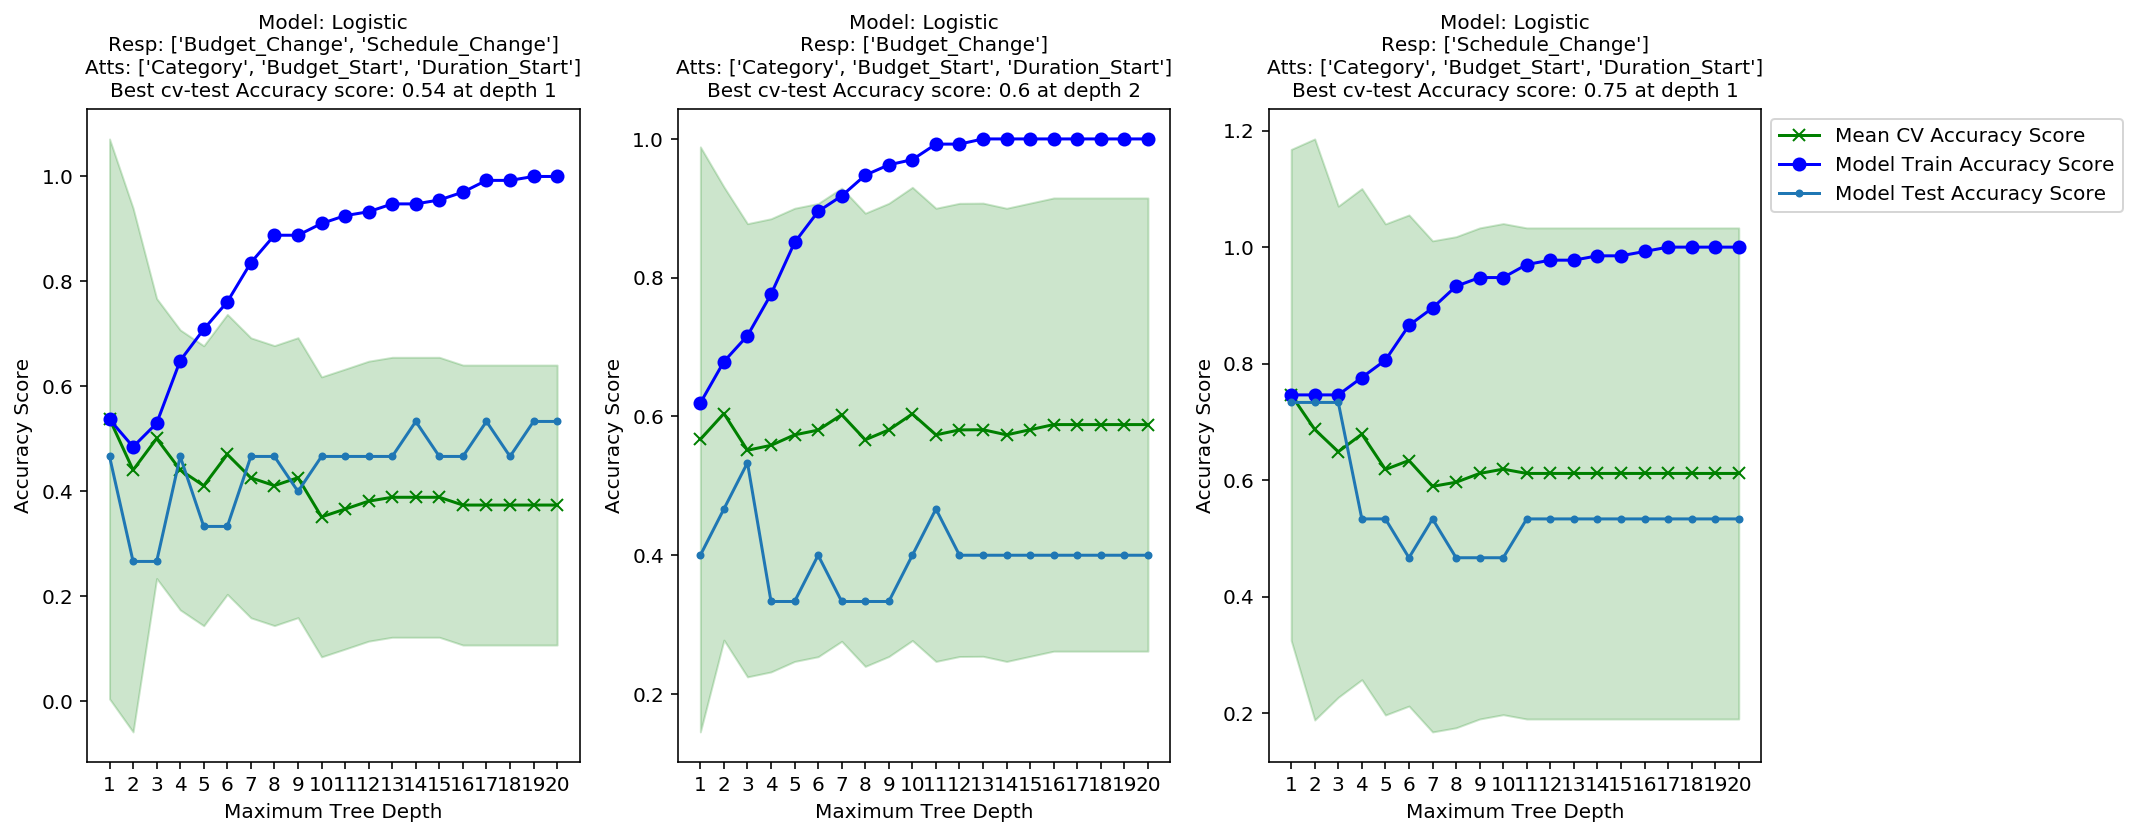

In [22]:
attributes = [  
                    'Category',
                    'Budget_Start',
                    'Duration_Start' 
             ]

dummy_columns = [
                    'Category', 
                ]

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

best_cv_score, best_depth, results, model_dict = plot_tree(data, dummy_columns, attributes=attributes, responses_list=responses_list, logistic=logistic)
results_all += results
model_dicts.append(model_dict)


Using Logistic Model


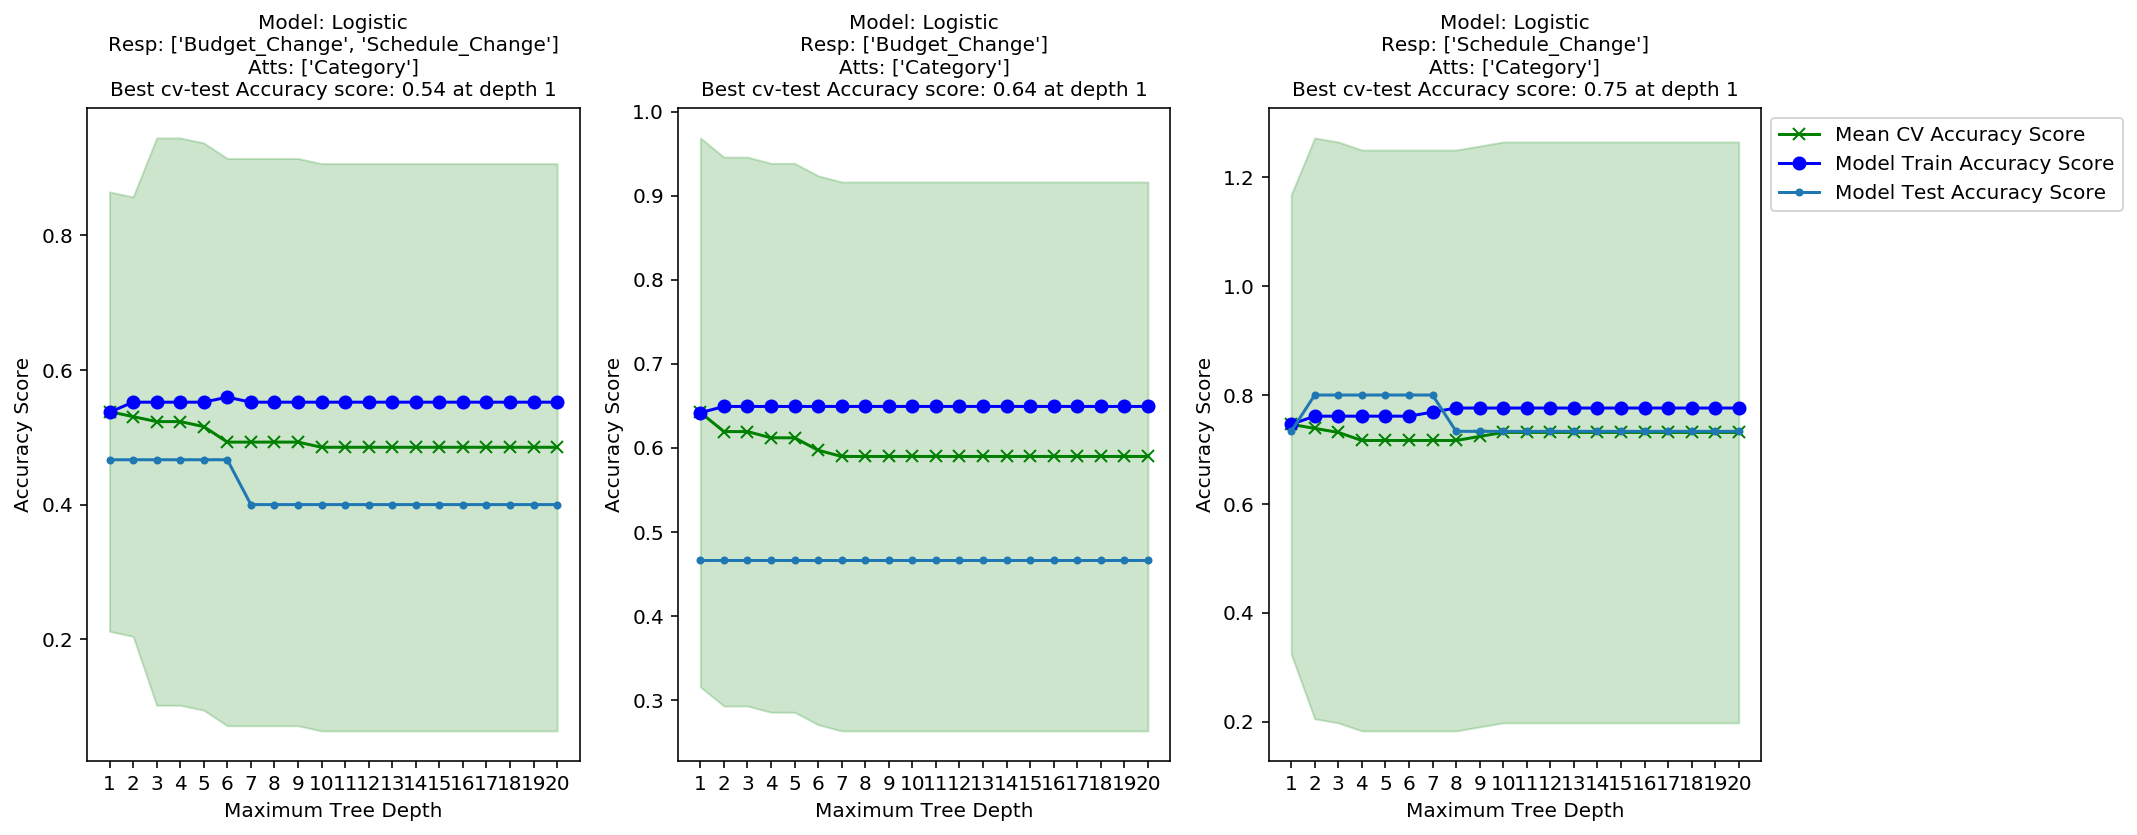

In [23]:
attributes = [  
                    'Category',
#                     'Budget_Start',
#                     'Duration_Start' 
             ]

dummy_columns = [
                    'Category', 
                ]

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

best_cv_score, best_depth, results, model_dict = plot_tree(data, dummy_columns, attributes=attributes, responses_list=responses_list, logistic=logistic)
results_all += results
model_dicts.append(model_dict)


Using Logistic Model


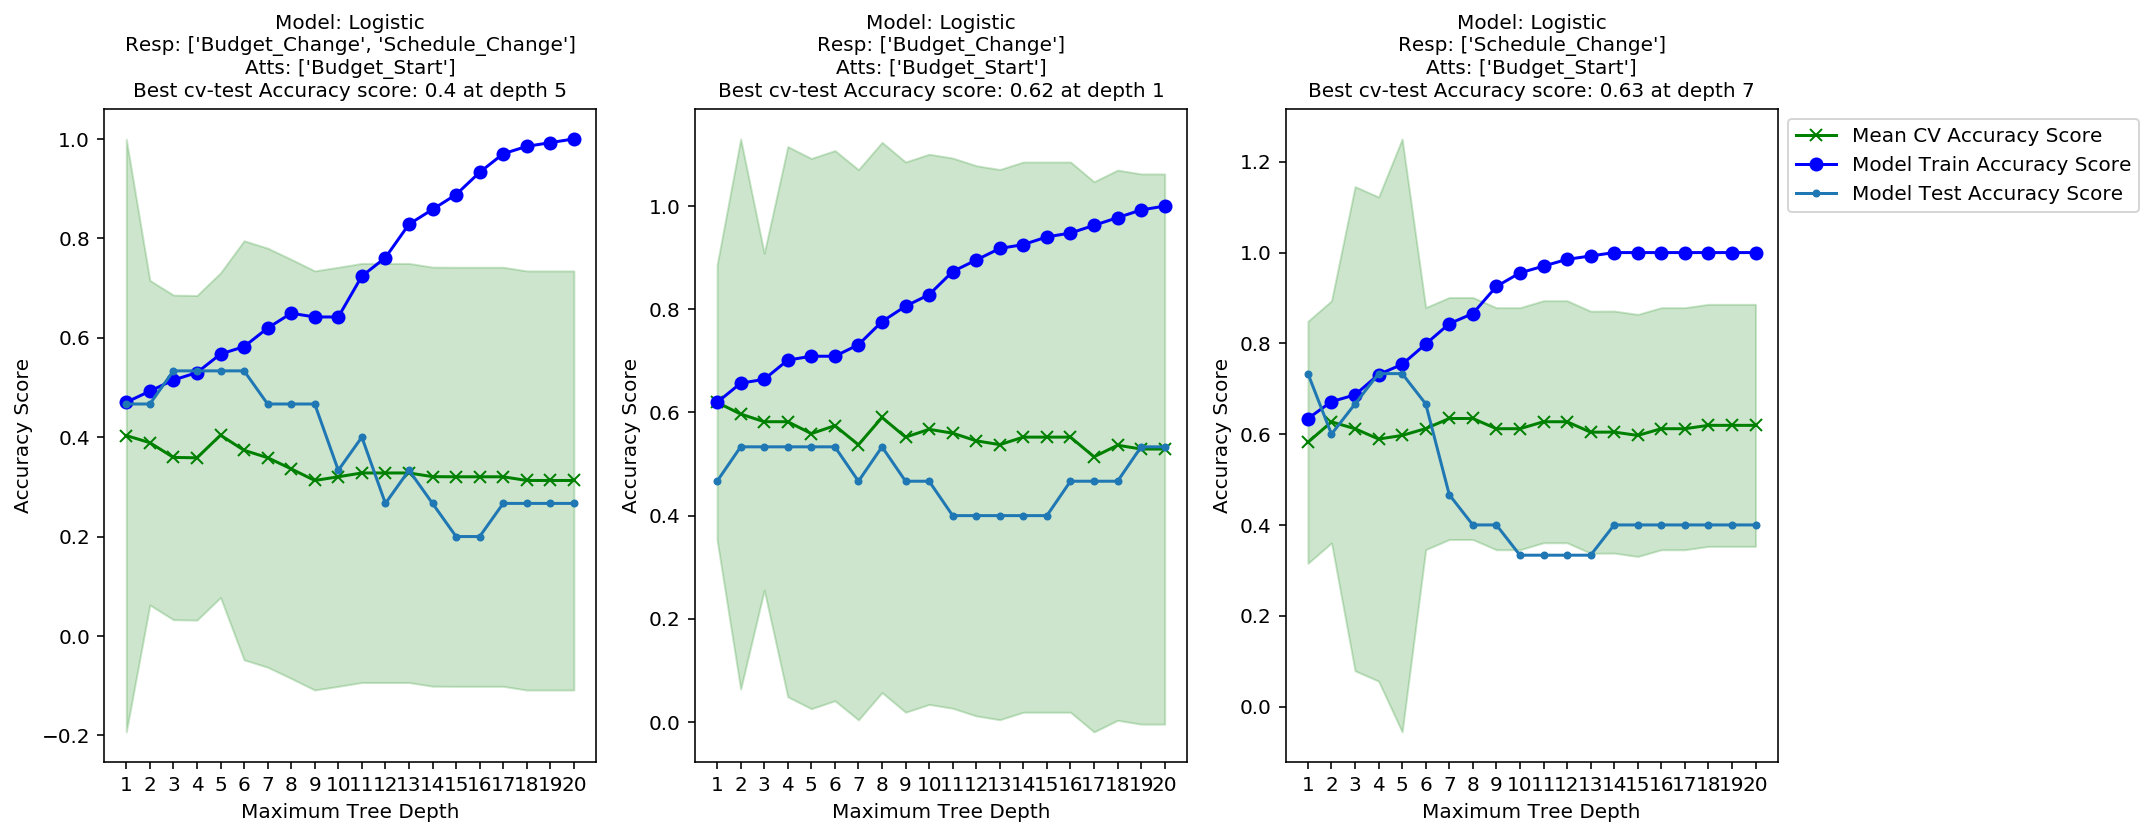

In [24]:
attributes = [  
#                     'Category',
                    'Budget_Start',
#                     'Duration_Start' 
             ]

dummy_columns = [
#                     'Category', 
                ]

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

best_cv_score, best_depth, results, model_dict = plot_tree(data, dummy_columns, attributes=attributes, responses_list=responses_list, logistic=logistic)
results_all += results
model_dicts.append(model_dict)


Using Logistic Model


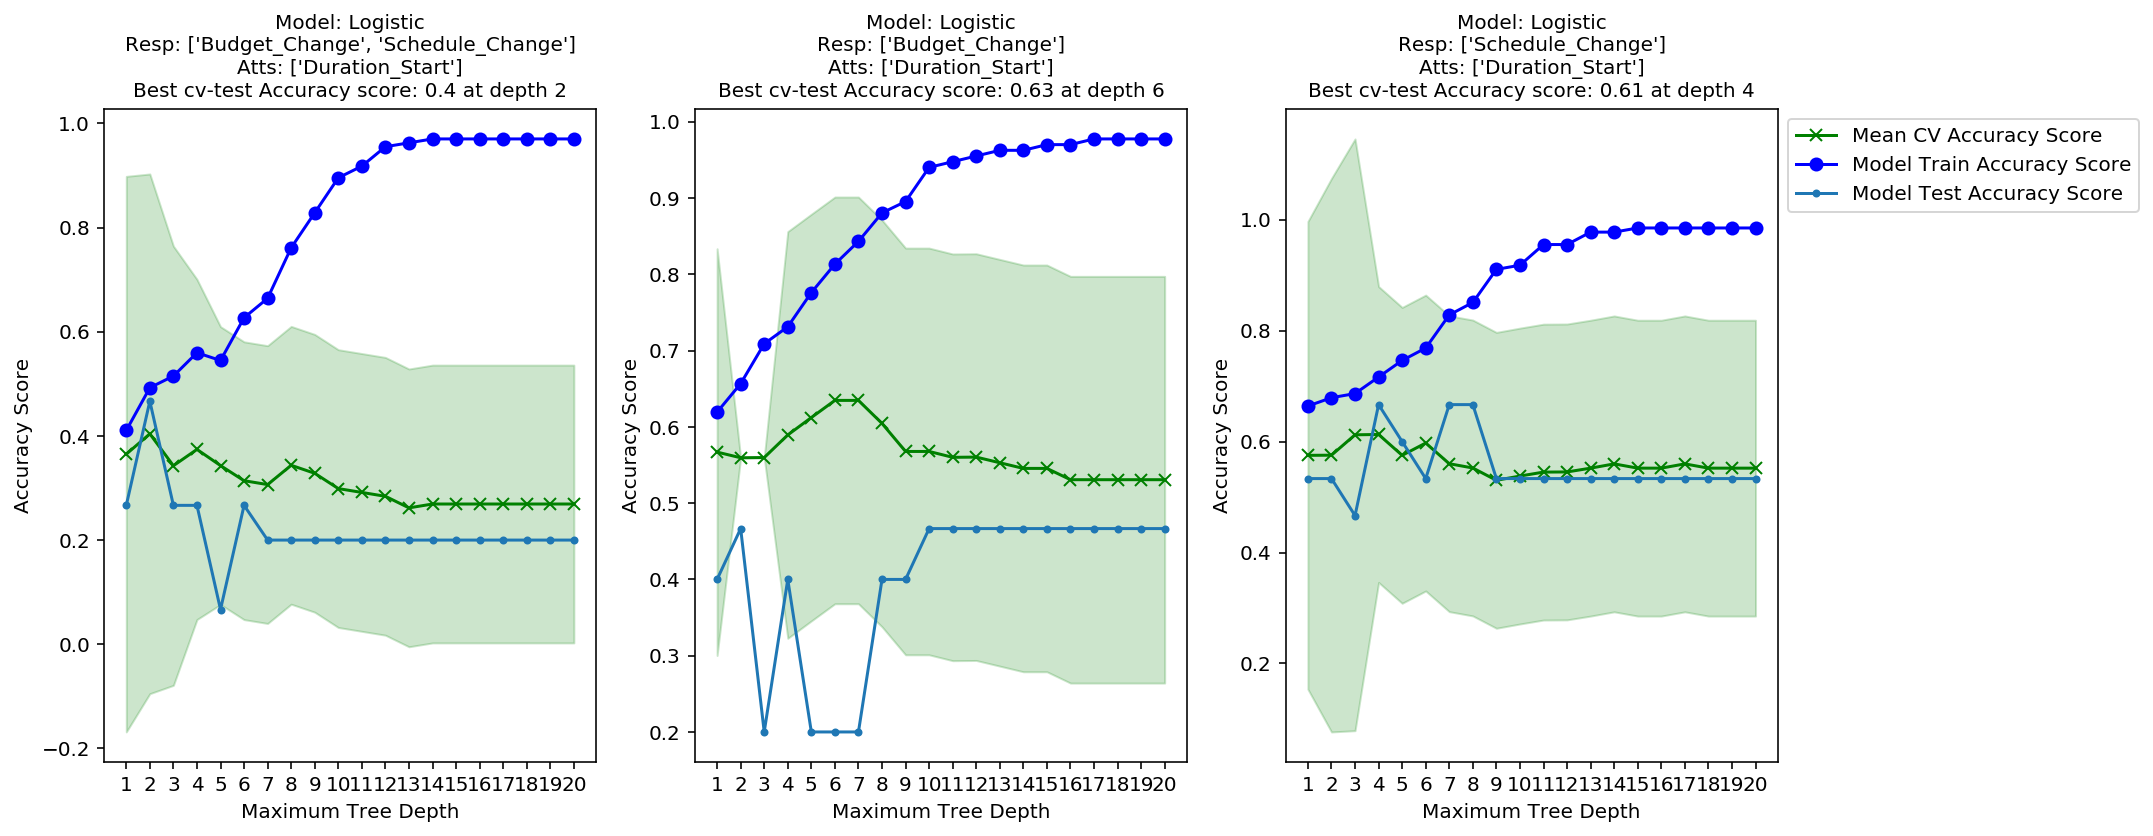

In [25]:
attributes = [  
#                     'Category',
#                     'Budget_Start',
                    'Duration_Start' 
             ]

dummy_columns = [
#                     'Category', 
                ]

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

best_cv_score, best_depth, results, model_dict = plot_tree(data, dummy_columns, attributes=attributes, responses_list=responses_list, logistic=logistic)
results_all += results
model_dicts.append(model_dict)


Using Logistic Model


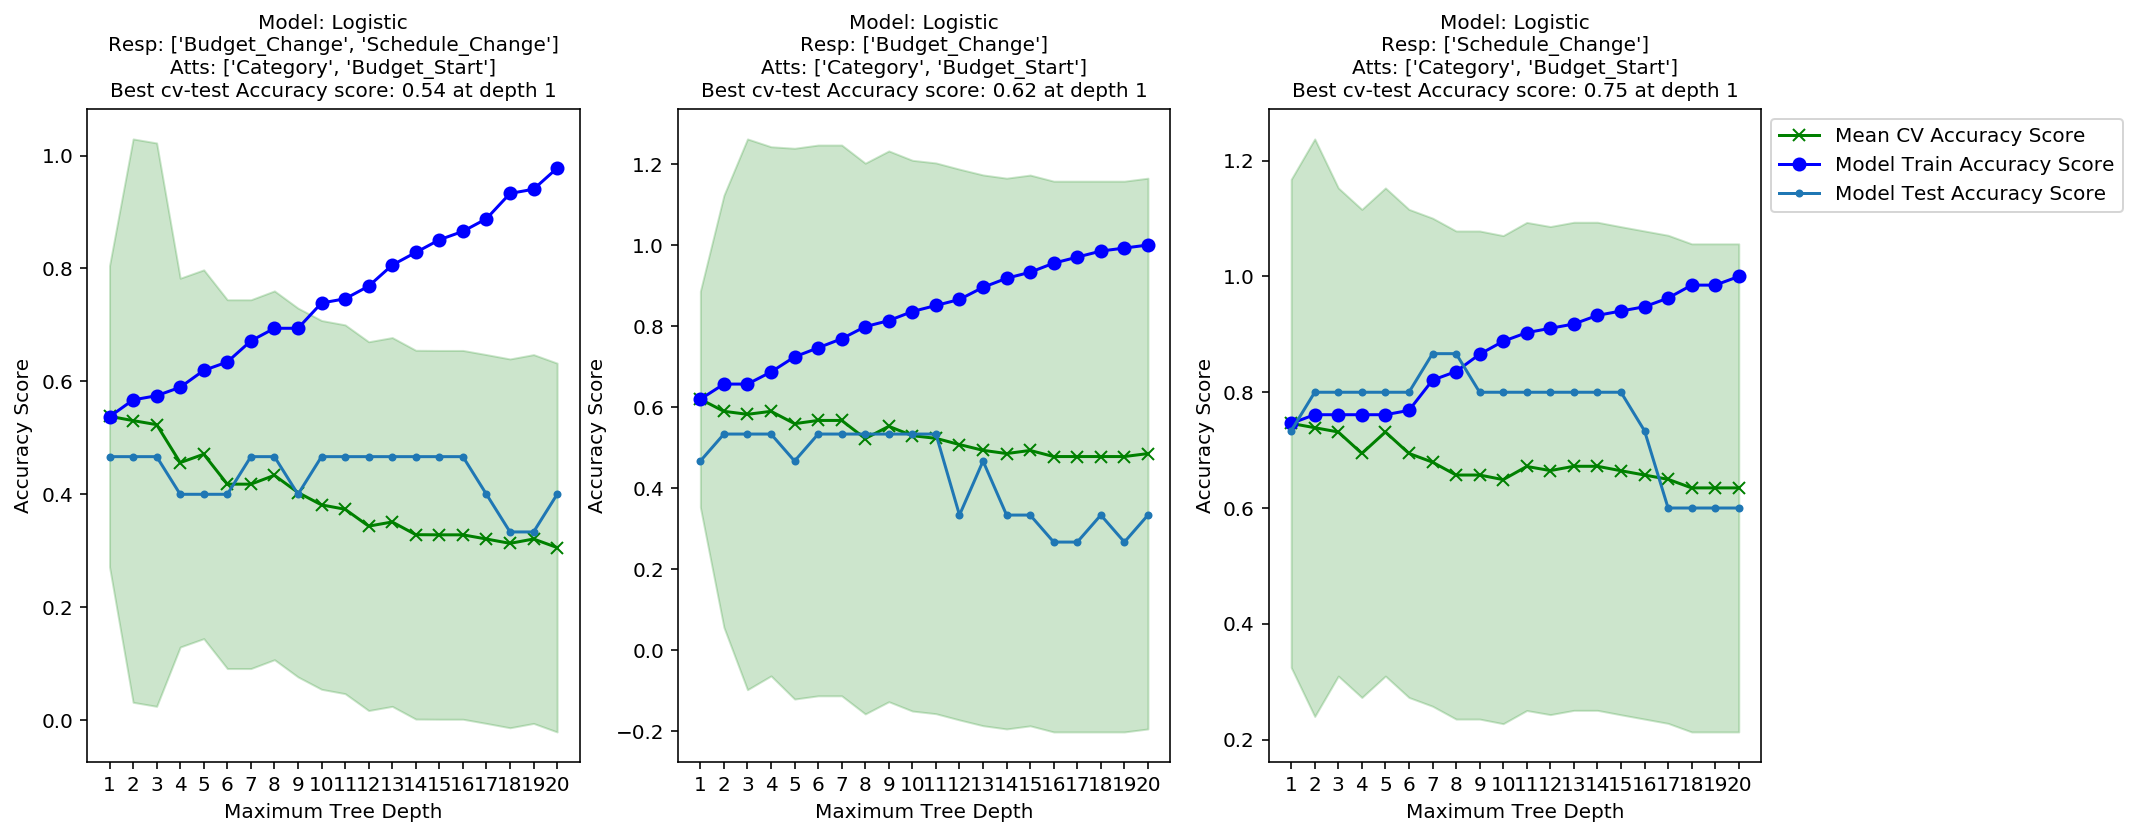

In [26]:
attributes = [  
                    'Category',
                    'Budget_Start',
#                     'Duration_Start' 
             ]

dummy_columns = [
                    'Category', 
                ]

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

best_cv_score, best_depth, results, model_dict = plot_tree(data, dummy_columns, attributes=attributes, responses_list=responses_list, logistic=logistic)
results_all += results
model_dicts.append(model_dict)


Using Logistic Model


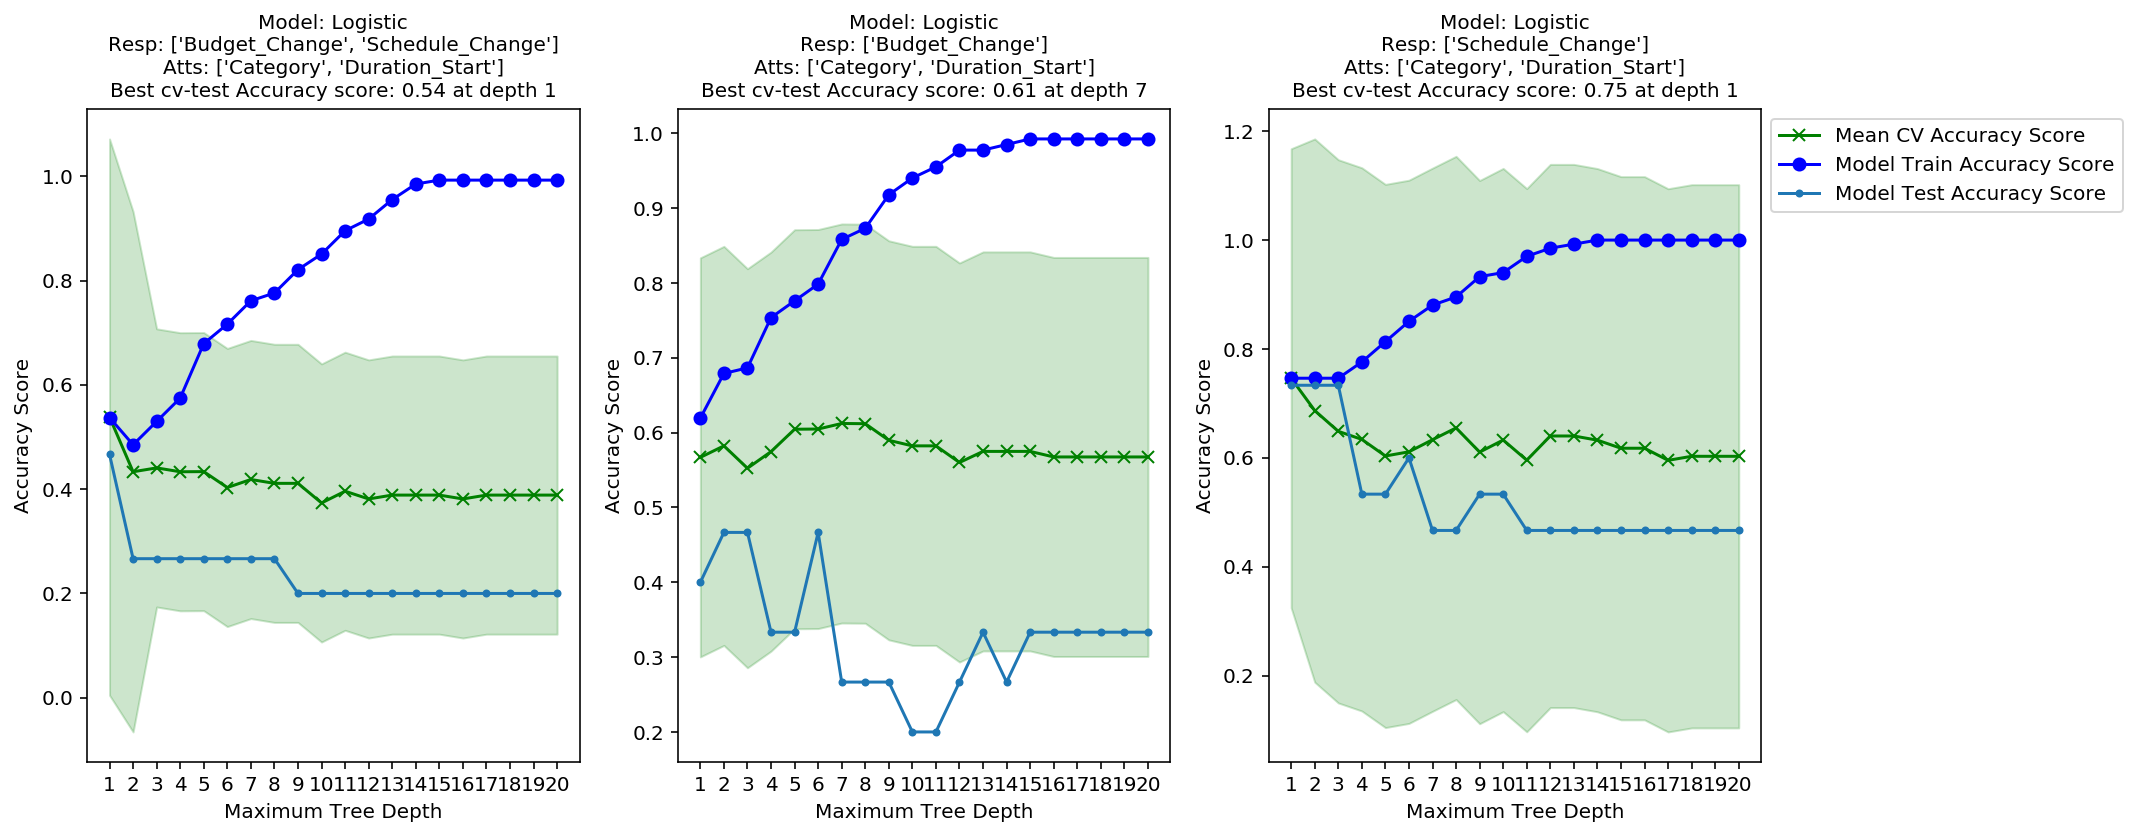

In [27]:
attributes = [  
                    'Category',
#                     'Budget_Start',
                    'Duration_Start' 
             ]

dummy_columns = [
                    'Category', 
                ]

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

best_cv_score, best_depth, results, model_dict = plot_tree(data, dummy_columns, attributes=attributes, responses_list=responses_list, logistic=logistic)
results_all += results
model_dicts.append(model_dict)


Using Logistic Model


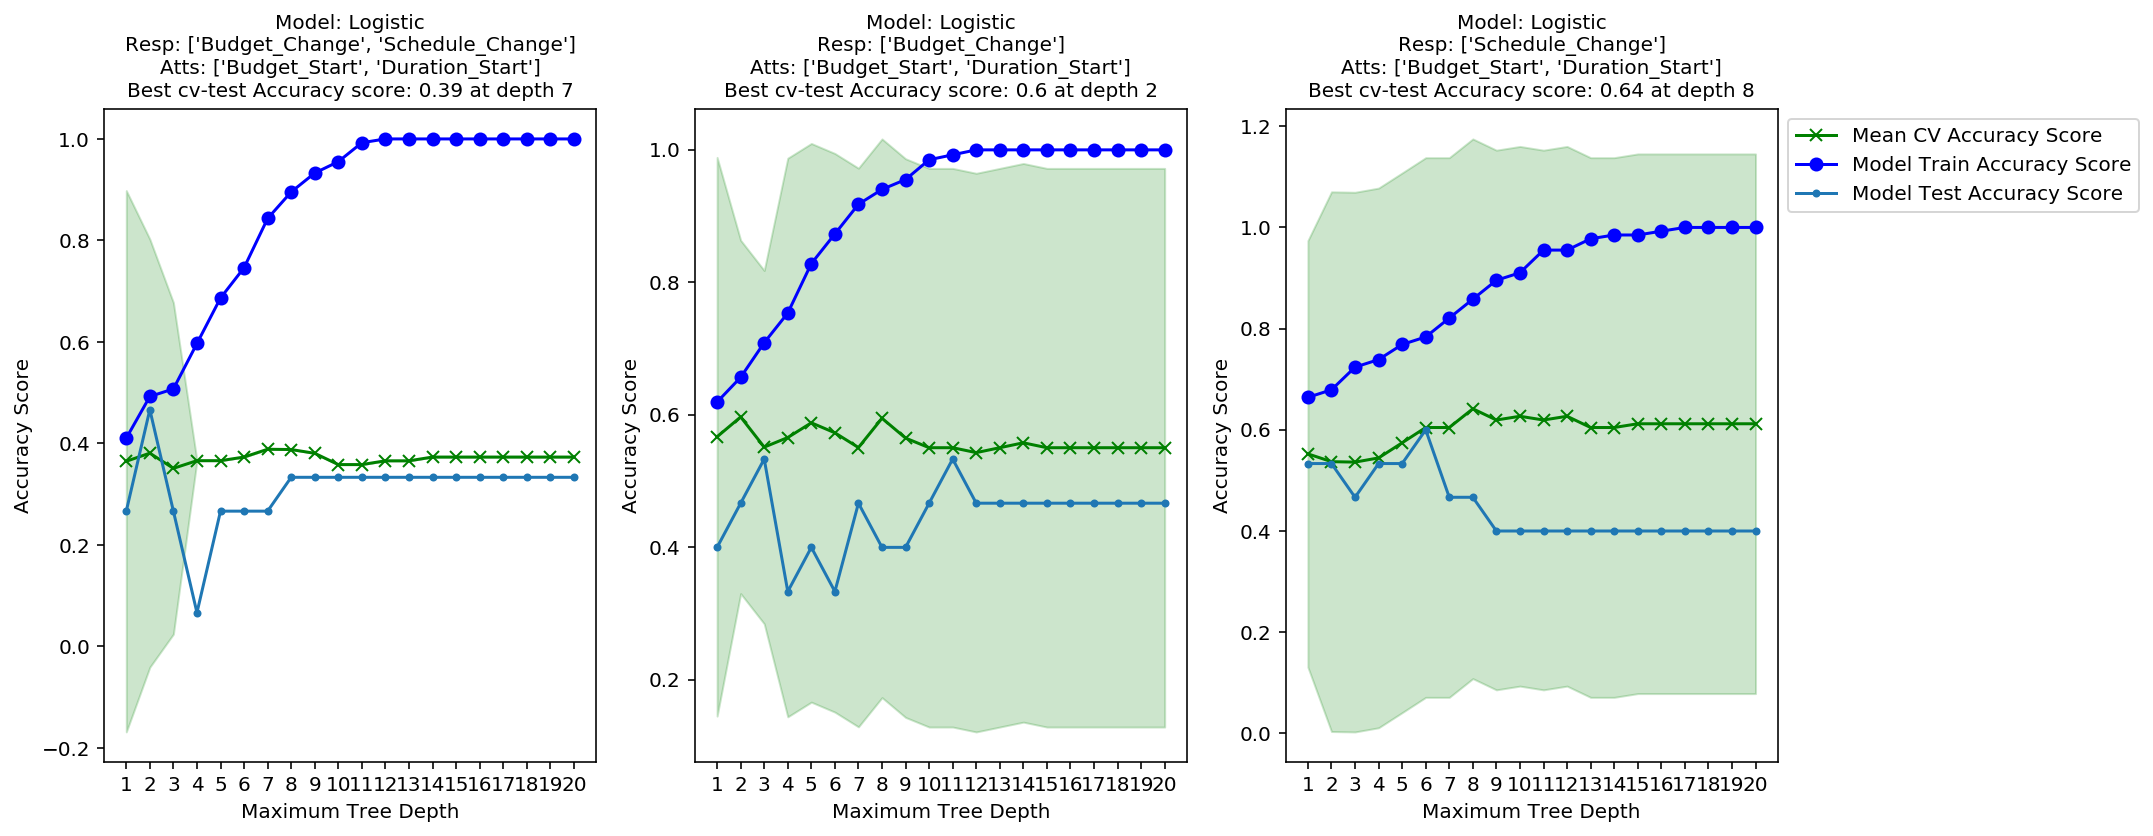

In [28]:
attributes = [  
#                     'Category',
                    'Budget_Start',
                    'Duration_Start' 
             ]

dummy_columns = [
#                     'Category', 
                ]

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

best_cv_score, best_depth, results, model_dict = plot_tree(data, dummy_columns, attributes=attributes, responses_list=responses_list, logistic=logistic)
results_all += results
model_dicts.append(model_dict)


Using Logistic Model


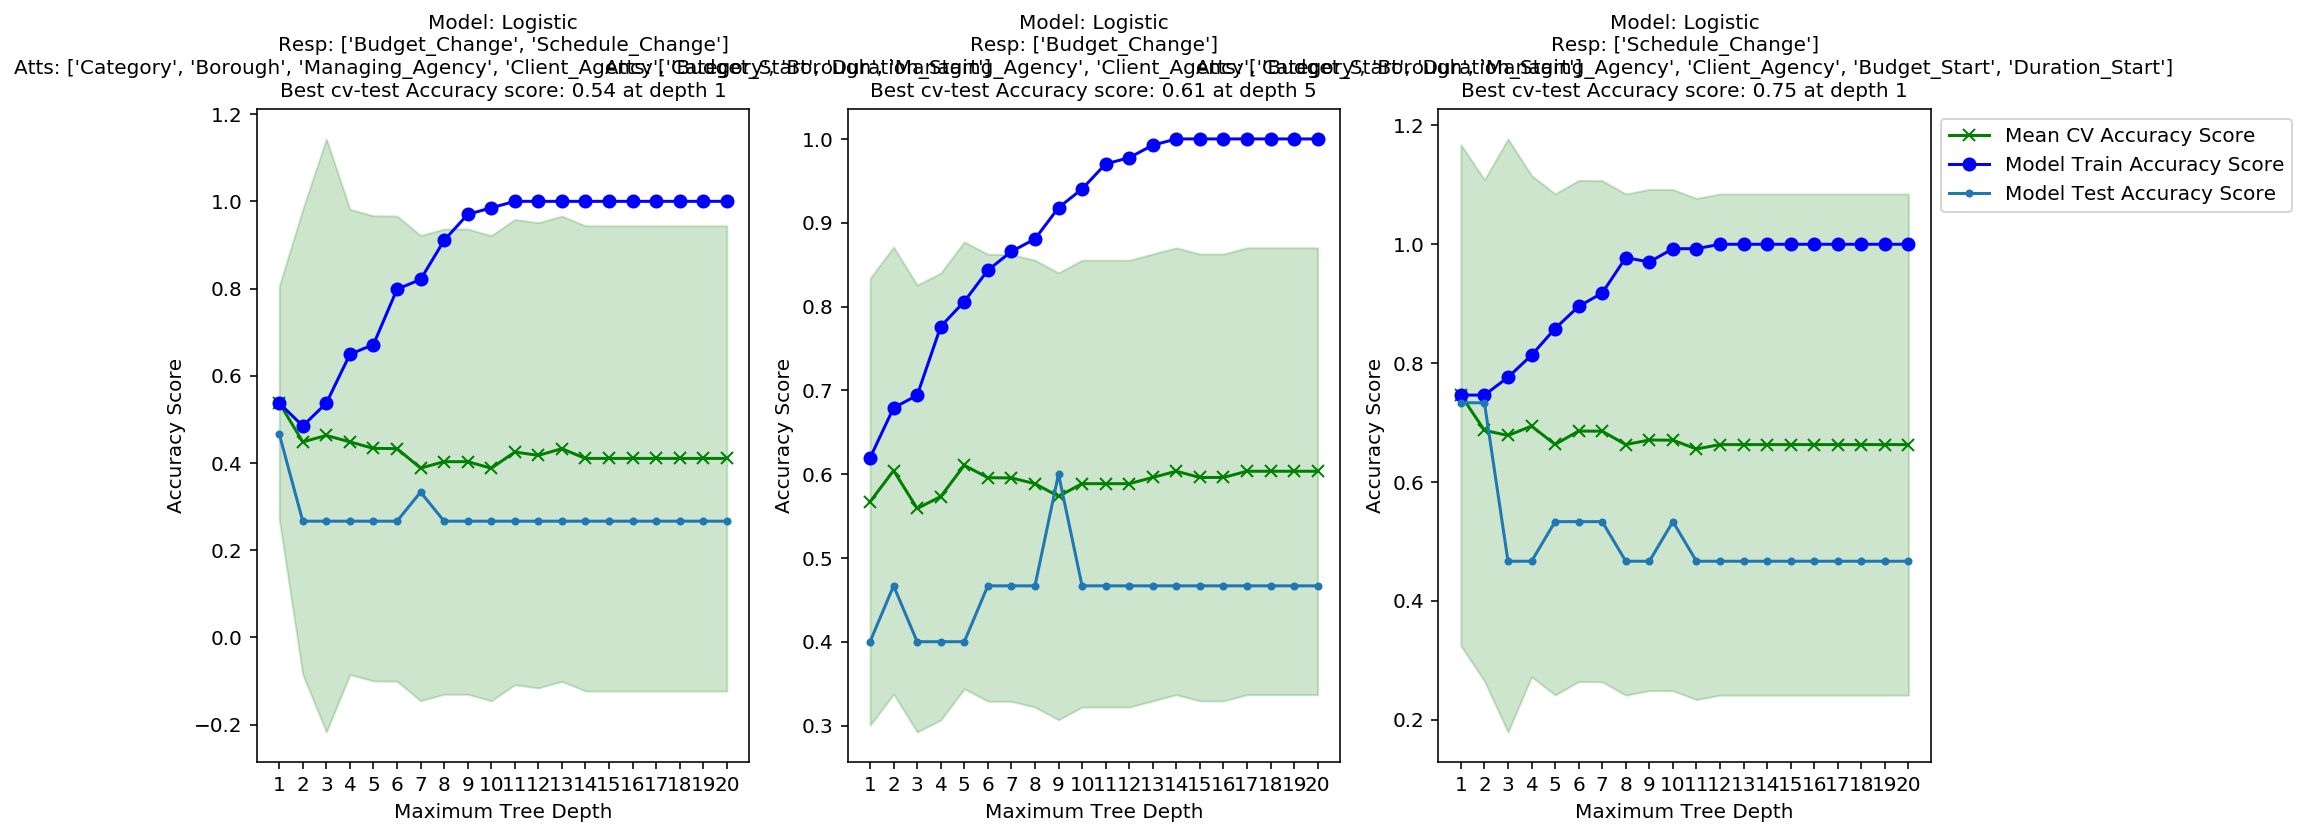

In [29]:
attributes = [  'Category',
                'Borough',
                'Managing_Agency',
                'Client_Agency',
                'Budget_Start',
                'Duration_Start' ]

dummy_columns = ['Category', 'Borough', 'Managing_Agency', 'Client_Agency']

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

best_cv_score, best_depth, results, model_dict = plot_tree(data, dummy_columns, attributes=attributes, responses_list=responses_list, logistic=logistic)
results_all += results
model_dicts.append(model_dict)


In [30]:
results_df = pd.DataFrame(results_all)
results_df[results_df['best_depth'] == 1]

attributes  \
0            [Category, Budget_Start, Duration_Start]   
2            [Category, Budget_Start, Duration_Start]   
3                                          [Category]   
4                                          [Category]   
5                                          [Category]   
7                                      [Budget_Start]   
12                           [Category, Budget_Start]   
13                           [Category, Budget_Start]   
14                           [Category, Budget_Start]   
15                         [Category, Duration_Start]   
17                         [Category, Duration_Start]   
21  [Category, Borough, Managing_Agency, Client_Ag...   
23  [Category, Borough, Managing_Agency, Client_Ag...   

                           responses  best_cv_score  best_depth  train_score  \
0   [Budget_Change, Schedule_Change]           0.54           1         0.54   
2                  [Schedule_Change]           0.75           1         0.75   
3   [Budget_Change, Schedule_Change]           0.54           1         0.54   
4                    [Budget_Change]           0.64           1         0.64   
5                  [Schedule_Change]           0.75           1         0.75   
7                    [Budget_Change]           0.62           1         0.62   
12  [Budget_Change, Schedule_Change]           0.54           1         0.54   
13                   [Budget_Change]           0.62           1         0.62   
14                 [Schedule_Change]           0.75           1         0.75   
15  [Budget_Change, Schedule_Change]           0.54           1         0.54   
17                 [Schedule_Change]           0.75           1         0.75   
21  [Budget_Change, Schedule_Change]           0.54           1         0.54   
23                 [Schedule_Change]           0.75           1         0.75   

    test_score                                         best_model  \
0         0.47  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
2         0.73  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
3         0.47  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
4         0.47  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
5         0.73  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
7         0.47  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
12        0.47  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
13        0.47  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
14        0.73  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
15        0.47  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
17        0.73  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
21        0.47  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
23        0.73  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   

                                         dummies_dict  
0   {'Category': ['Sewers', 'Streets_and_Roadways'...  
2   {'Category': ['Sewers', 'Streets_and_Roadways'...  
3   {'Category': ['Sewers', 'Streets_and_Roadways'...  
4   {'Category': ['Sewers', 'Streets_and_Roadways'...  
5   {'Category': ['Sewers', 'Streets_and_Roadways'...  
7                                                  {}  
12  {'Category': ['Sewers', 'Streets_and_Roadways'...  
13  {'Category': ['Sewers', 'Streets_and_Roadways'...  
14  {'Category': ['Sewers', 'Streets_and_Roadways'...  
15  {'Category': ['Sewers', 'Streets_and_Roadways'...  
17  {'Category': ['Sewers', 'Streets_and_Roadways'...  
21  {'Category': ['Sewers', 'Streets_and_Roadways'...  
23  {'Category': ['Sewers', 'Streets_and_Roadways'...

In [31]:
results_df[results_df['best_depth'] != 1]

attributes  \
1            [Category, Budget_Start, Duration_Start]   
6                                      [Budget_Start]   
8                                      [Budget_Start]   
9                                    [Duration_Start]   
10                                   [Duration_Start]   
11                                   [Duration_Start]   
16                         [Category, Duration_Start]   
18                     [Budget_Start, Duration_Start]   
19                     [Budget_Start, Duration_Start]   
20                     [Budget_Start, Duration_Start]   
22  [Category, Borough, Managing_Agency, Client_Ag...   

                           responses  best_cv_score  best_depth  train_score  \
1                    [Budget_Change]           0.60           2         0.68   
6   [Budget_Change, Schedule_Change]           0.40           5         0.57   
8                  [Schedule_Change]           0.63           7         0.84   
9   [Budget_Change, Schedule_Change]           0.40           2         0.49   
10                   [Budget_Change]           0.63           6         0.81   
11                 [Schedule_Change]           0.61           4         0.72   
16                   [Budget_Change]           0.61           7         0.86   
18  [Budget_Change, Schedule_Change]           0.39           7         0.84   
19                   [Budget_Change]           0.60           2         0.66   
20                 [Schedule_Change]           0.64           8         0.86   
22                   [Budget_Change]           0.61           5         0.81   

    test_score                                         best_model  \
1         0.47  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
6         0.53  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
8         0.47  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
9         0.47  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
10        0.20  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
11        0.67  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
16        0.27  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
18        0.27  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
19        0.47  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
20        0.47  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
22        0.40  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   

                                         dummies_dict  
1   {'Category': ['Sewers', 'Streets_and_Roadways'...  
6                                                  {}  
8                                                  {}  
9                                                  {}  
10                                                 {}  
11                                                 {}  
16  {'Category': ['Sewers', 'Streets_and_Roadways'...  
18                                                 {}  
19                                                 {}  
20                                                 {}  
22  {'Category': ['Sewers', 'Streets_and_Roadways'...

### This is not conclusive, but there is some correlation
The tree is trained on all combinations of the input attributes and responses.

Most results report the best depth of 1, indicating a single attribute is used to determine the response.  These are not very insightful models and are not considered valid.  Models with depths > 1 are considered for subsequent evaluation.

### Observations
Using the models that generated their best score at a depth > 1, we can make some observations that will help us look further.  Looking at the 2 best scoring models:

- Using only the category as a model attribute, we can predict schedule changes with a reasonable amount of accuracy. This indicates that there is a category of project that has a predictable outome on the schedule.
- Combining the Budget Start value with the category as attributes creates a model that predicts schedule changes reasonably well.

Addional Observation:
- Perhaps not initially evident is the model which uses Duration Start as an attribute and predicts both responses.  This model scores .40 indicating that from just he Duration start value alone, we can predict the budget and schedule changes with .40 accuracy.  For 2 responses, guessing yields a .25 score, so the .40 is significant.


## Analyze the deepest tree

Index Chosen: 20
Best CV Score of Model Chosen: 0.64 // Depth: 8
Model Attributes: ['Budget_Start', 'Duration_Start']
Model Response: ['Schedule_Change']


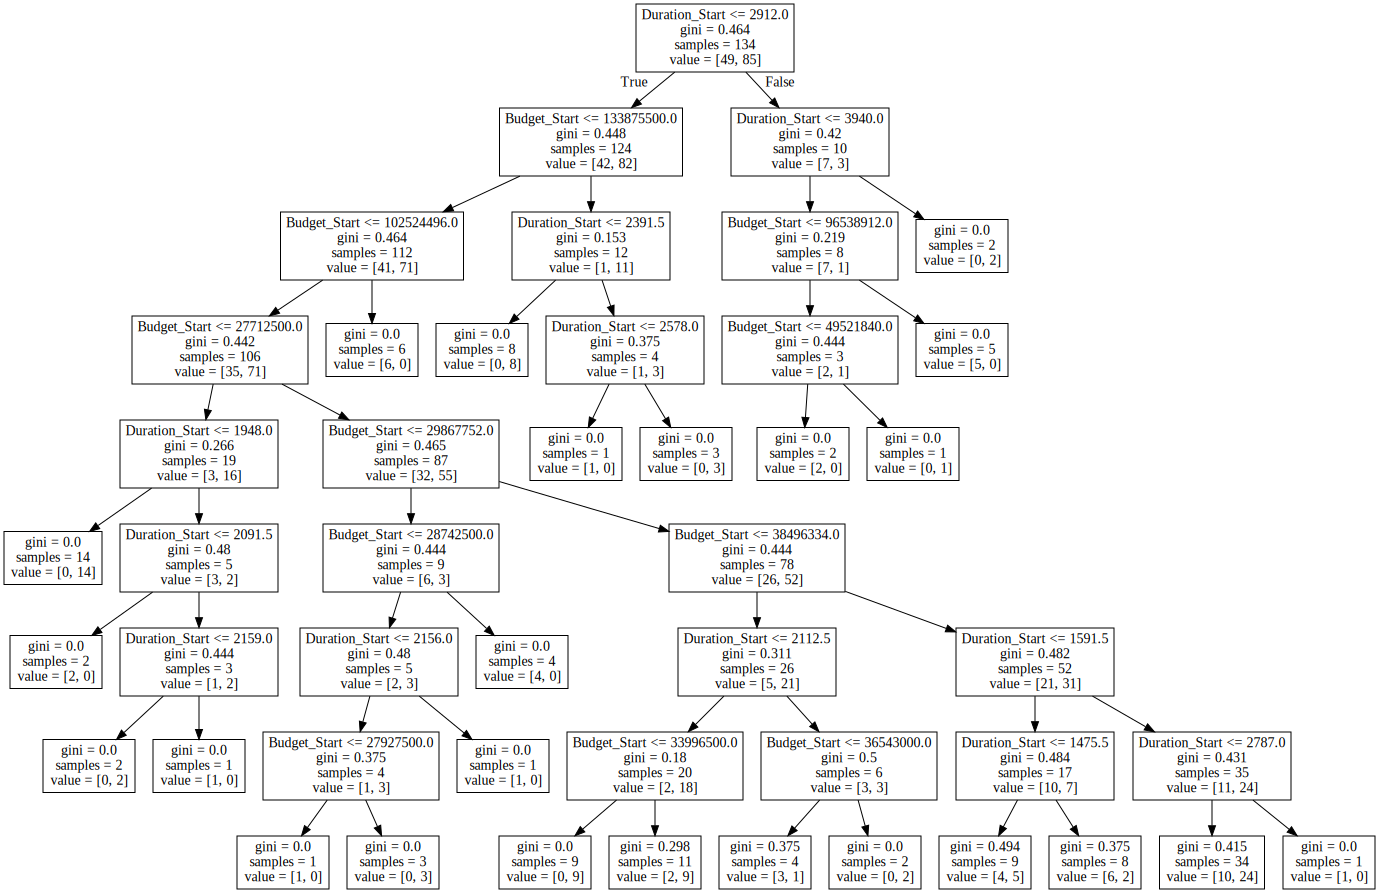

In [32]:
# deepest tree model
idx = results_df.best_depth.idxmax()
print(f"Index Chosen: {idx}")

m_dict = results_df.iloc[idx]
print(f"Best CV Score of Model Chosen: {m_dict.get('best_cv_score')} // Depth: {m_dict.get('best_depth')}")
print(f"Model Attributes: {m_dict.get('attributes')}")
print(f"Model Response: {m_dict.get('responses')}")

xtree = m_dict.best_model

if len(m_dict.dummies_dict) == 0:
    tree_dot_data = tree.export_graphviz(xtree, feature_names=m_dict.attributes)
else:
    tree_dot_data = tree.export_graphviz(xtree, feature_names=list(set(m_dict.attributes) - set(m_dict.dummies_dict.keys())) + m_dict.dummies_dict.get('Category'))
    
gr = graphviz.Source(tree_dot_data)
display(gr)

### Here, a variety of Budget_start, Duration_Start and some project categories values are used as breaking points to determine the ending values.  No simple rule is easy to extrapolate which is often the case with a reasonably deep decision tree model.

Index Chosen: 9
Best CV Score of Model Chosen: 0.4 // Depth: 2
Model Attributes: ['Duration_Start']
Model Response: ['Budget_Change', 'Schedule_Change']


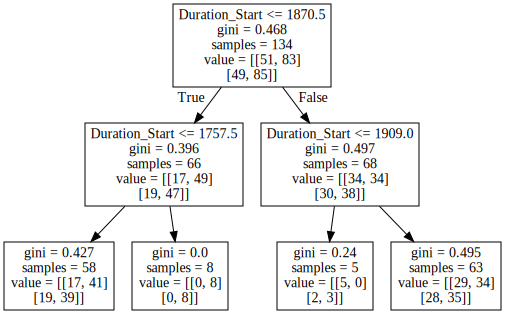

In [33]:
# deepest tree model
idx = 9
print(f"Index Chosen: {idx}")

m_dict = results_df.iloc[idx]
print(f"Best CV Score of Model Chosen: {m_dict.get('best_cv_score')} // Depth: {m_dict.get('best_depth')}")
print(f"Model Attributes: {m_dict.get('attributes')}")
print(f"Model Response: {m_dict.get('responses')}")

xtree = m_dict.best_model

if len(m_dict.dummies_dict) == 0:
    tree_dot_data = tree.export_graphviz(xtree, feature_names=m_dict.attributes)
else:
    tree_dot_data = tree.export_graphviz(xtree, feature_names=list(set(m_dict.attributes) - set(m_dict.dummies_dict.keys())) + m_dict.dummies_dict.get('Category'))
    
gr = graphviz.Source(tree_dot_data)
display(gr)

### Here, the other multi-ouput model which shared a best score with the previous model is based on the Duration_start attribute.  We see that there is a pattern in the duration start values. Based on this, we could expect to see some type of grouping in starting duration values in the intervals [1757, 1870, 1909] (in days) as these are decision critera at various levels of the tree.  

## Analyze the Best Scoring Model 
5 models produced the best score.  Each yields an indentical decision tree. <br>
This indicates that 'Cateogry' is the most impactful attribute since adding new attributes add no increased value to the score. <br>
Additionally, the best scoring models are all predicting 'Schedule_Change'.

In [34]:
results_df[results_df['best_cv_score'] == max(results_df['best_cv_score'])]

attributes          responses  \
2            [Category, Budget_Start, Duration_Start]  [Schedule_Change]   
5                                          [Category]  [Schedule_Change]   
14                           [Category, Budget_Start]  [Schedule_Change]   
17                         [Category, Duration_Start]  [Schedule_Change]   
23  [Category, Borough, Managing_Agency, Client_Ag...  [Schedule_Change]   

    best_cv_score  best_depth  train_score  test_score  \
2            0.75           1         0.75        0.73   
5            0.75           1         0.75        0.73   
14           0.75           1         0.75        0.73   
17           0.75           1         0.75        0.73   
23           0.75           1         0.75        0.73   

                                           best_model  \
2   DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
5   DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
14  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
17  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
23  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   

                                         dummies_dict  
2   {'Category': ['Sewers', 'Streets_and_Roadways'...  
5   {'Category': ['Sewers', 'Streets_and_Roadways'...  
14  {'Category': ['Sewers', 'Streets_and_Roadways'...  
17  {'Category': ['Sewers', 'Streets_and_Roadways'...  
23  {'Category': ['Sewers', 'Streets_and_Roadways'...

Index Chosen: 2
Best CV Score of Model Chosen: 0.75 // Depth: 1
Model Attributes: ['Category', 'Budget_Start', 'Duration_Start']
Model Response: ['Schedule_Change']


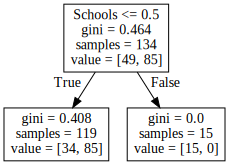

In [35]:
idx = results_df.best_cv_score.idxmax() #2, 5, 14, 17 , 23 
print(f"Index Chosen: {idx}")

m_dict = results_df.iloc[idx]
print(f"Best CV Score of Model Chosen: {m_dict.get('best_cv_score')} // Depth: {m_dict.get('best_depth')}")
print(f"Model Attributes: {m_dict.get('attributes')}")
print(f"Model Response: {m_dict.get('responses')}")

xtree = m_dict.best_model

if len(m_dict.dummies_dict) == 0:
    tree_dot_data = tree.export_graphviz(xtree, feature_names=m_dict.attributes)
else:
    tree_dot_data = tree.export_graphviz(xtree, feature_names=list(set(m_dict.attributes) - set(m_dict.dummies_dict.keys())) + m_dict.dummies_dict.get('Category'))
    
gr = graphviz.Source(tree_dot_data)
display(gr)

### This isn't very exciting.  Projects that are schools or not have some predictive value.

### Analyze the best scoring multi_output model
We observe two multi-output models that share the same best score.

In [36]:
multioutputs = results_df[(results_df.responses.apply(len) == 2)  & (results_df.best_depth != 1)]
multioutputs[multioutputs['best_cv_score'] == multioutputs['best_cv_score'].max()]

attributes                         responses  best_cv_score  \
6    [Budget_Start]  [Budget_Change, Schedule_Change]           0.40   
9  [Duration_Start]  [Budget_Change, Schedule_Change]           0.40   

   best_depth  train_score  test_score  \
6           5         0.57        0.53   
9           2         0.49        0.47   

                                          best_model dummies_dict  
6  DecisionTreeClassifier(ccp_alpha=0.0, class_we...           {}  
9  DecisionTreeClassifier(ccp_alpha=0.0, class_we...           {}

Index Chosen: 6
Best CV Score of Model Chosen: 0.4 // Depth: 5
Model Attributes: ['Budget_Start']
Model Response: ['Budget_Change', 'Schedule_Change']


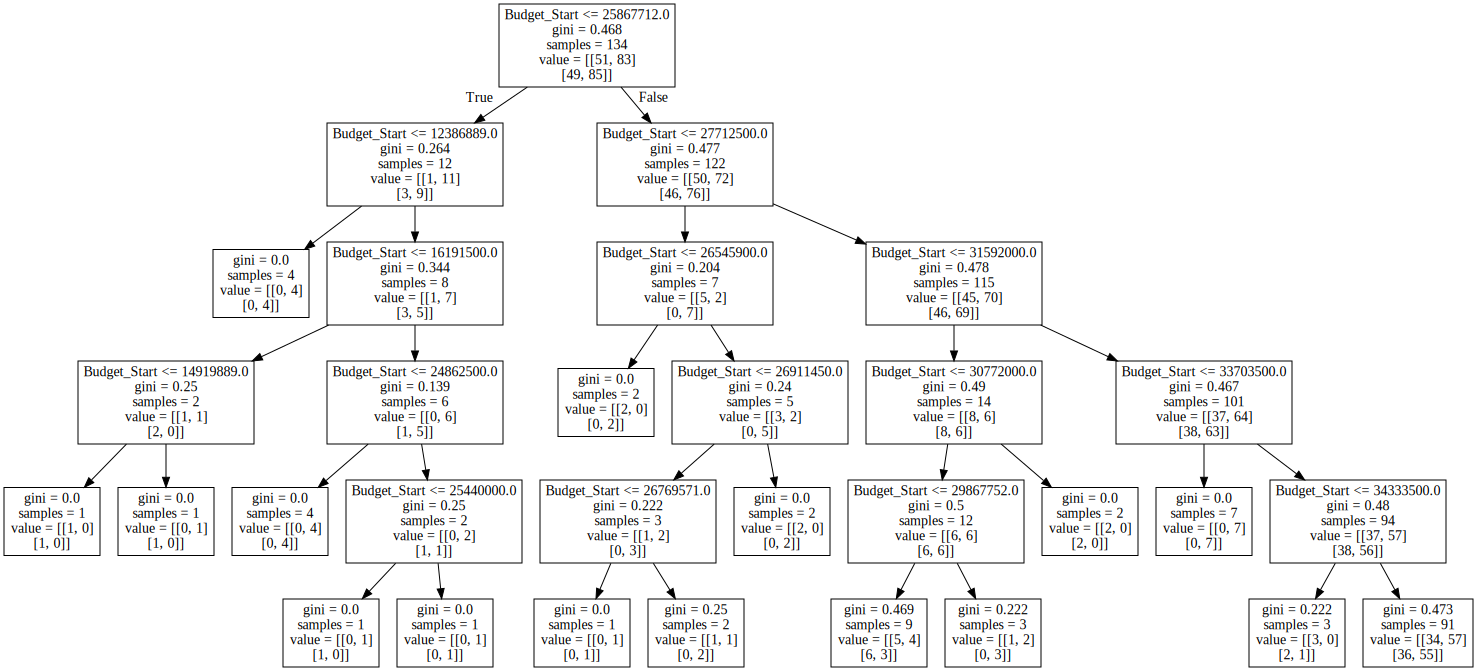

In [37]:

idx = 6 #6, 9 results_df[(results_df.responses.apply(len) == 2)  & (results_df.best_depth != 1)].best_cv_score.idxmax()
print(f"Index Chosen: {idx}")

m_dict = results_df.iloc[idx]
print(f"Best CV Score of Model Chosen: {m_dict.get('best_cv_score')} // Depth: {m_dict.get('best_depth')}")
print(f"Model Attributes: {m_dict.get('attributes')}")
print(f"Model Response: {m_dict.get('responses')}")

xtree = m_dict.best_model

if len(m_dict.dummies_dict) == 0:
    tree_dot_data = tree.export_graphviz(xtree, feature_names=m_dict.attributes)
else:
    tree_dot_data = tree.export_graphviz(xtree, feature_names=list(set(m_dict.attributes) - set(m_dict.dummies_dict.keys())) + m_dict.dummies_dict.get('Category'))
    
gr = graphviz.Source(tree_dot_data)
display(gr)

Index Chosen: 9
Best CV Score of Model Chosen: 0.4 // Depth: 2
Model Attributes: ['Duration_Start']
Model Response: ['Budget_Change', 'Schedule_Change']


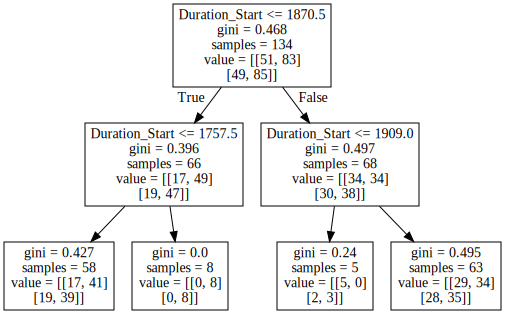

In [38]:

idx = 9 #6, 9 results_df[(results_df.responses.apply(len) == 2)  & (results_df.best_depth != 1)].best_cv_score.idxmax()
print(f"Index Chosen: {idx}")

m_dict = results_df.iloc[idx]
print(f"Best CV Score of Model Chosen: {m_dict.get('best_cv_score')} // Depth: {m_dict.get('best_depth')}")
print(f"Model Attributes: {m_dict.get('attributes')}")
print(f"Model Response: {m_dict.get('responses')}")

xtree = m_dict.best_model

if len(m_dict.dummies_dict) == 0:
    tree_dot_data = tree.export_graphviz(xtree, feature_names=m_dict.attributes)
else:
    tree_dot_data = tree.export_graphviz(xtree, feature_names=list(set(m_dict.attributes) - set(m_dict.dummies_dict.keys())) + m_dict.dummies_dict.get('Category'))
    
gr = graphviz.Source(tree_dot_data)
display(gr)

### This is interesting.  The first multi-output model is based on Budget_Start and builds a significantly complex tree to determine the outcomes.
### The second tree is based on Duration_Start and finds the same breaking points that we found ealier [1757, 1870, 1909] (in days).

## Random Forest
Extend the Decision Tree concept by creating a forest of trees where each tree in the forest is a decision tree model with a random starting point.  Using a random forest may uncover some hidden relationships that the decision tree may not find.

In [39]:
n_trees = 150
tree_depth = 6
rf = RandomForestClassifier(   n_estimators=n_trees, 
                               max_depth=tree_depth, 
                               bootstrap=True,
                               oob_score=True,
                               n_jobs=-1, 
                               random_state=0)

In [40]:
# for the forest, we will use all attributes and responses.  Non-essential variables will be 'weeded out' by the forest model.
attributes = [  'Category',
                'Borough',
                'Managing_Agency',
                'Client_Agency',
                'Budget_Start',
                'Duration_Start' ]

dummy_columns = ['Category', 'Borough', 'Managing_Agency', 'Client_Agency']

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

X_tr, X_te, y_tr, y_te, dummies_dict = define_train_and_test(data, dummy_columns, attributes, responses_list[0], logistic==True) 


In [41]:
rf.fit(X_tr, y_tr)
random_forest_train_score = rf.score(X_tr, y_tr)
random_forest_test_score = rf.score(X_te, y_te)
print("Random Forest performance with {} baggings and tree depth of {}:".format(n_trees, tree_depth))
print("\tRandom Forest Train Score: {}%".format(round(random_forest_train_score*100,2)))
print("\tRandom Forest Test Score: {}%".format(round(random_forest_test_score*100,2)))

Random Forest performance with 150 baggings and tree depth of 6:
	Random Forest Train Score: 73.88%
	Random Forest Test Score: 26.67%


In [42]:
pd.DataFrame({'features':X_tr.columns, 'importance':rf.feature_importances_}).sort_values(by='importance', ascending=False).head()


features  importance
1   Duration_Start        0.19
0     Budget_Start        0.14
11         Schools        0.08
36             DOE        0.07
28             SCA        0.07

### Using a random forecast, we use a model that creates numerous decision trees starting with randome initial starting points.  We reach a similar score as with our simple manual decision tree which help comfirm that we may have selected the most important features in our Tree model.  When analyzing the most important features of the random forest, we see that Budget_Start and Duration_Start are the most important.  This somewhat aligns with the Tree models we reviewed as these features by themselves drive some of the better performing tree models.  

### Using Regression Models

In [43]:
results_all = []
model_dicts = []

In [44]:
logistic = False

Using Regression Model

MODEL SUMMARY:
Regression Tree. Depth: 3


The fitted model object(s):

	DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

	DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')


This model resulted in the following R-squared scores:

	Budget_Change

		Training	0.9065
		Test		-0.0625

	S

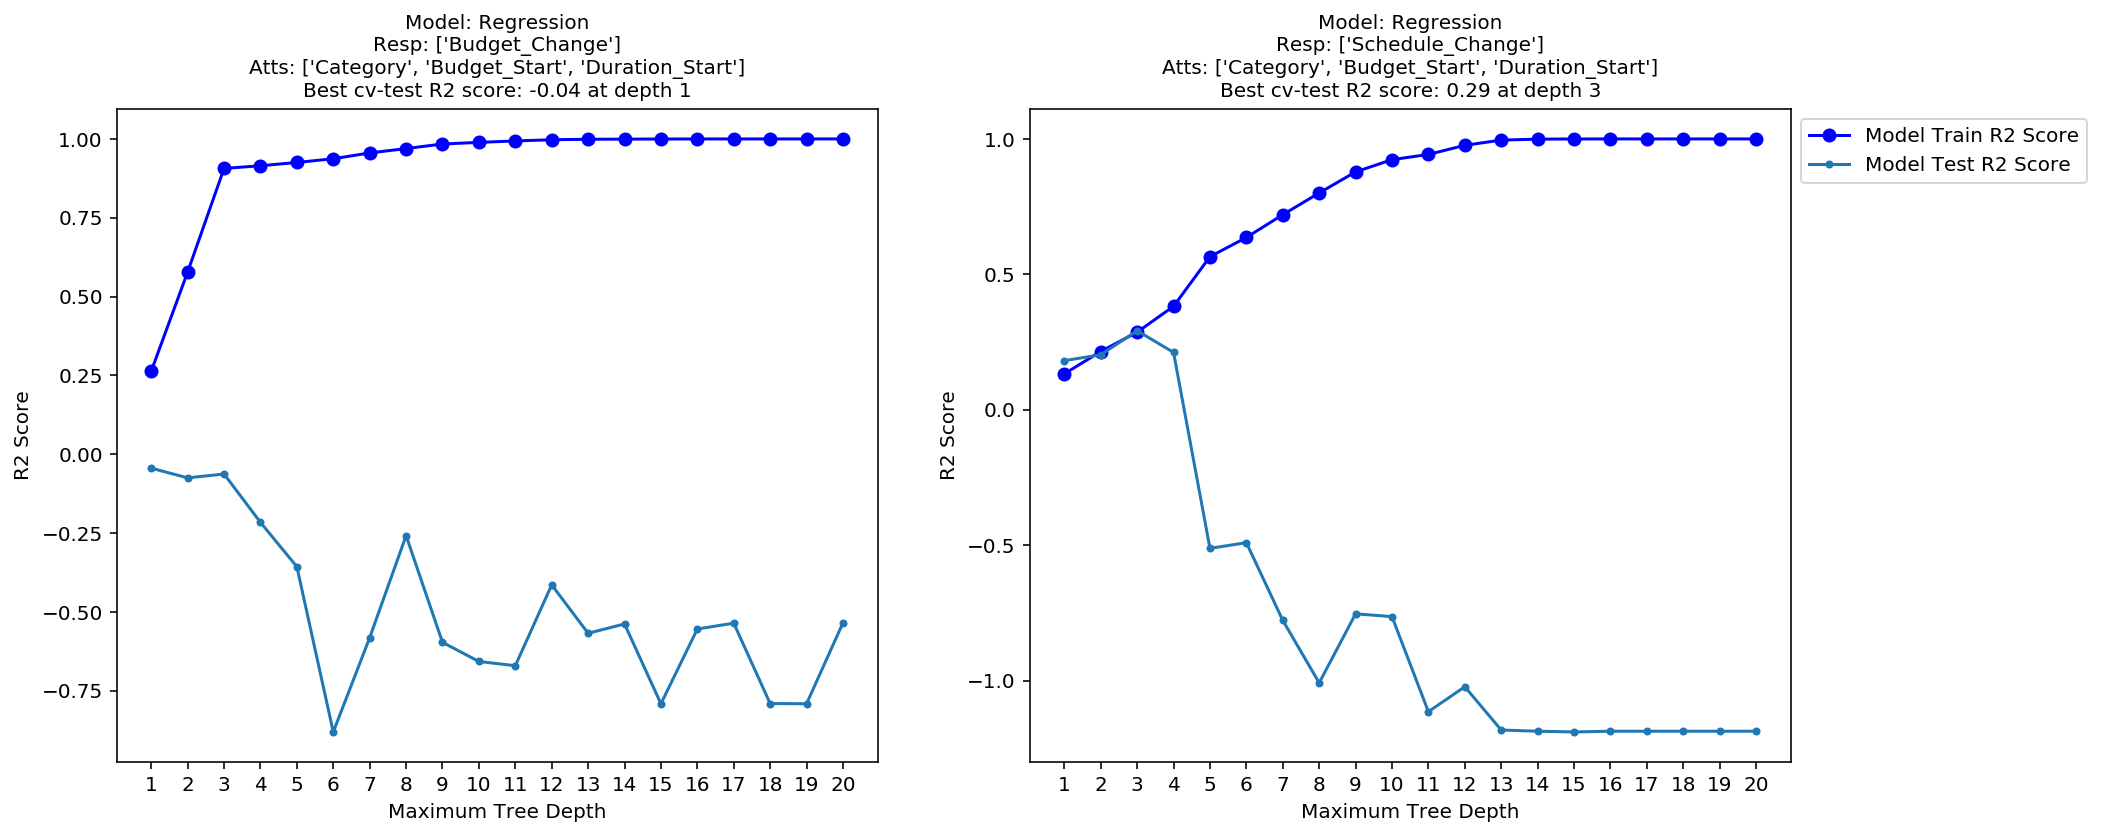

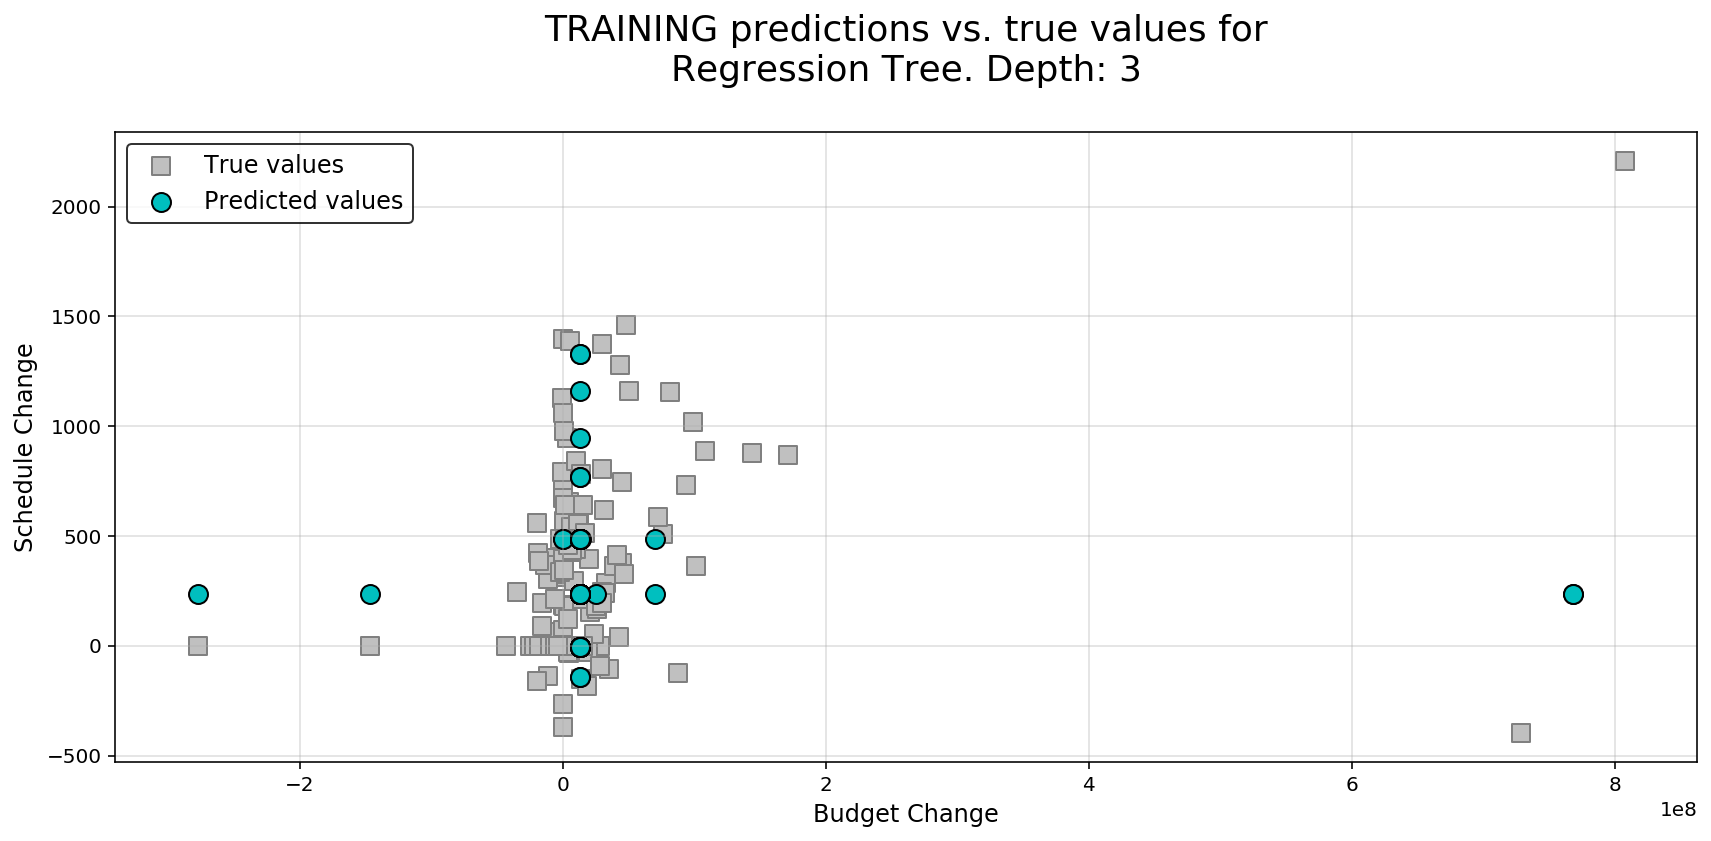

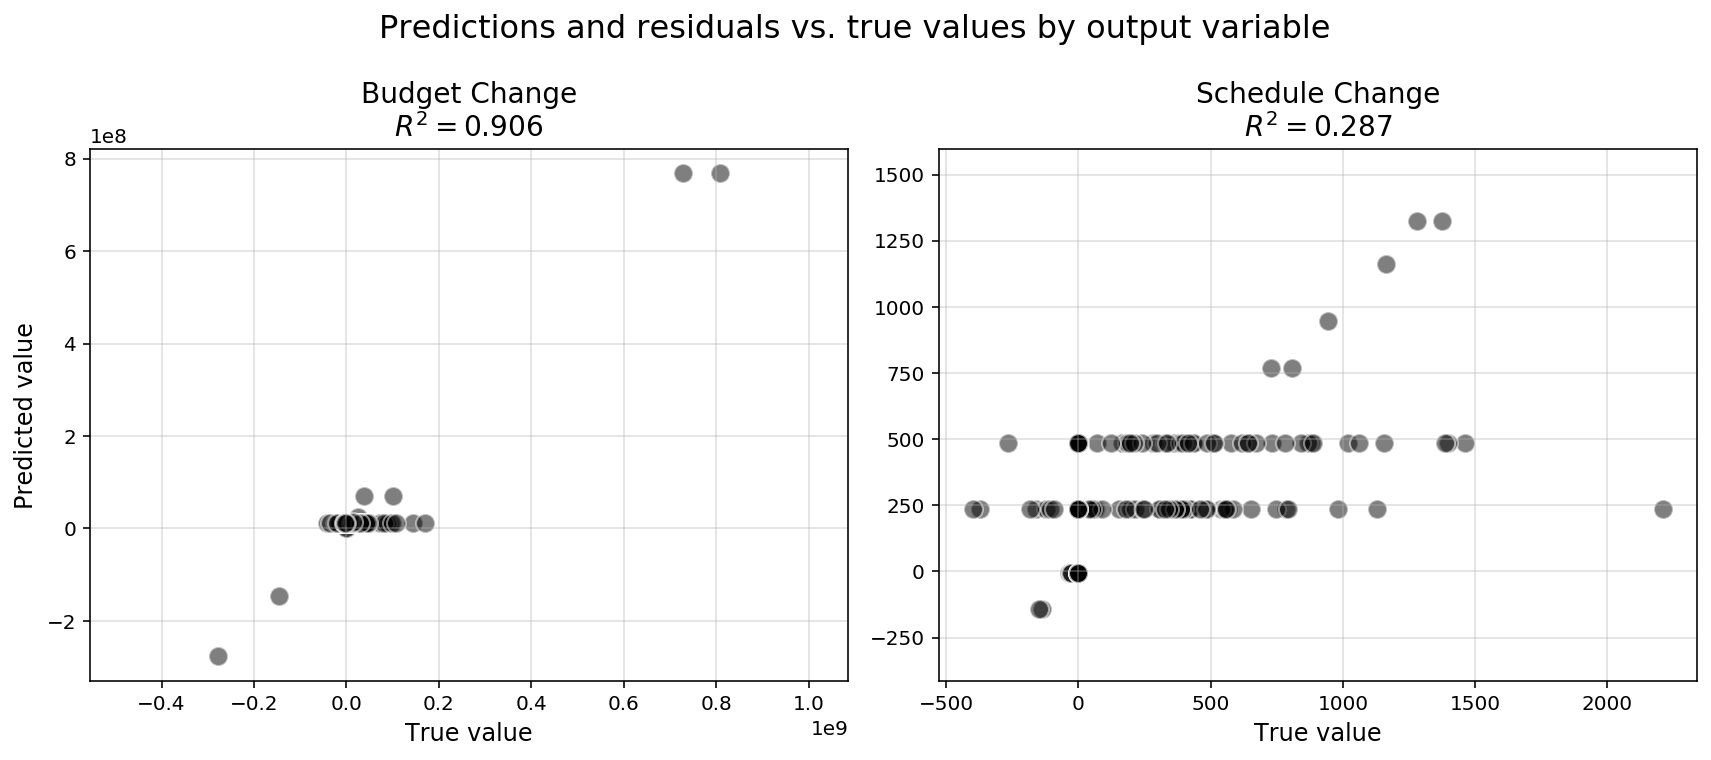

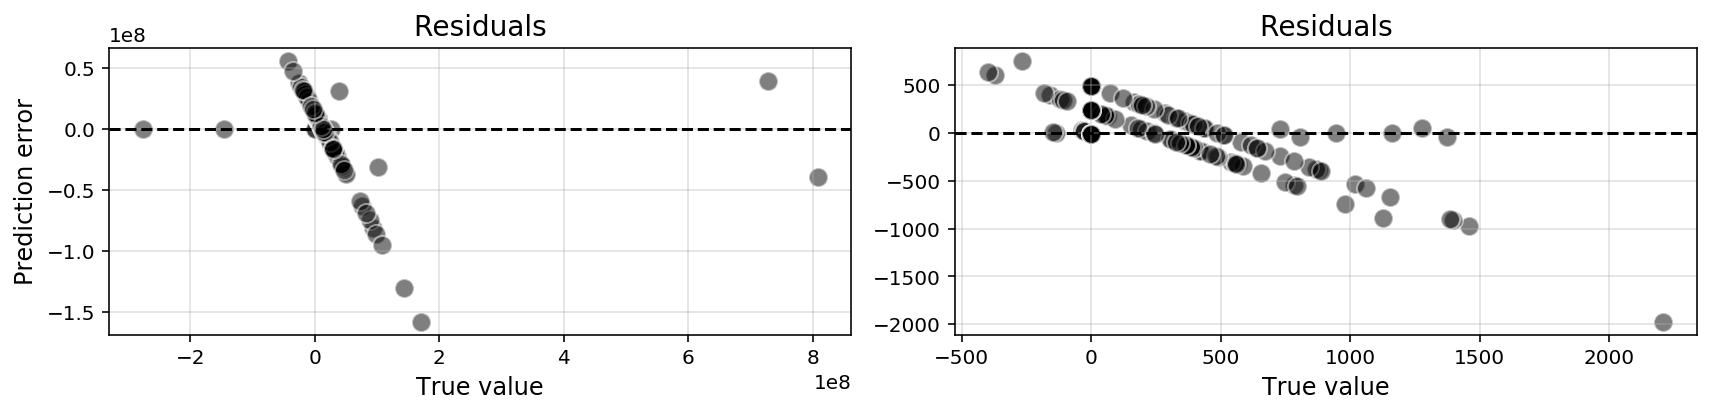

In [45]:
attributes = [  
                    'Category',
                    'Budget_Start',
                    'Duration_Start' 
             ]

dummy_columns = [
                    'Category', 
                ]

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

best_cv_score, best_depth, results, model_dict = plot_tree(data, dummy_columns, attributes=attributes, responses_list=responses_list, logistic=logistic)
results_all += results
model_dicts.append(model_dict)


Using Regression Model

MODEL SUMMARY:
Regression Tree. Depth: 3


The fitted model object(s):

	DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

	DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')


This model resulted in the following R-squared scores:

	Budget_Change

		Training	0.0709
		Test		-0.2406

	S

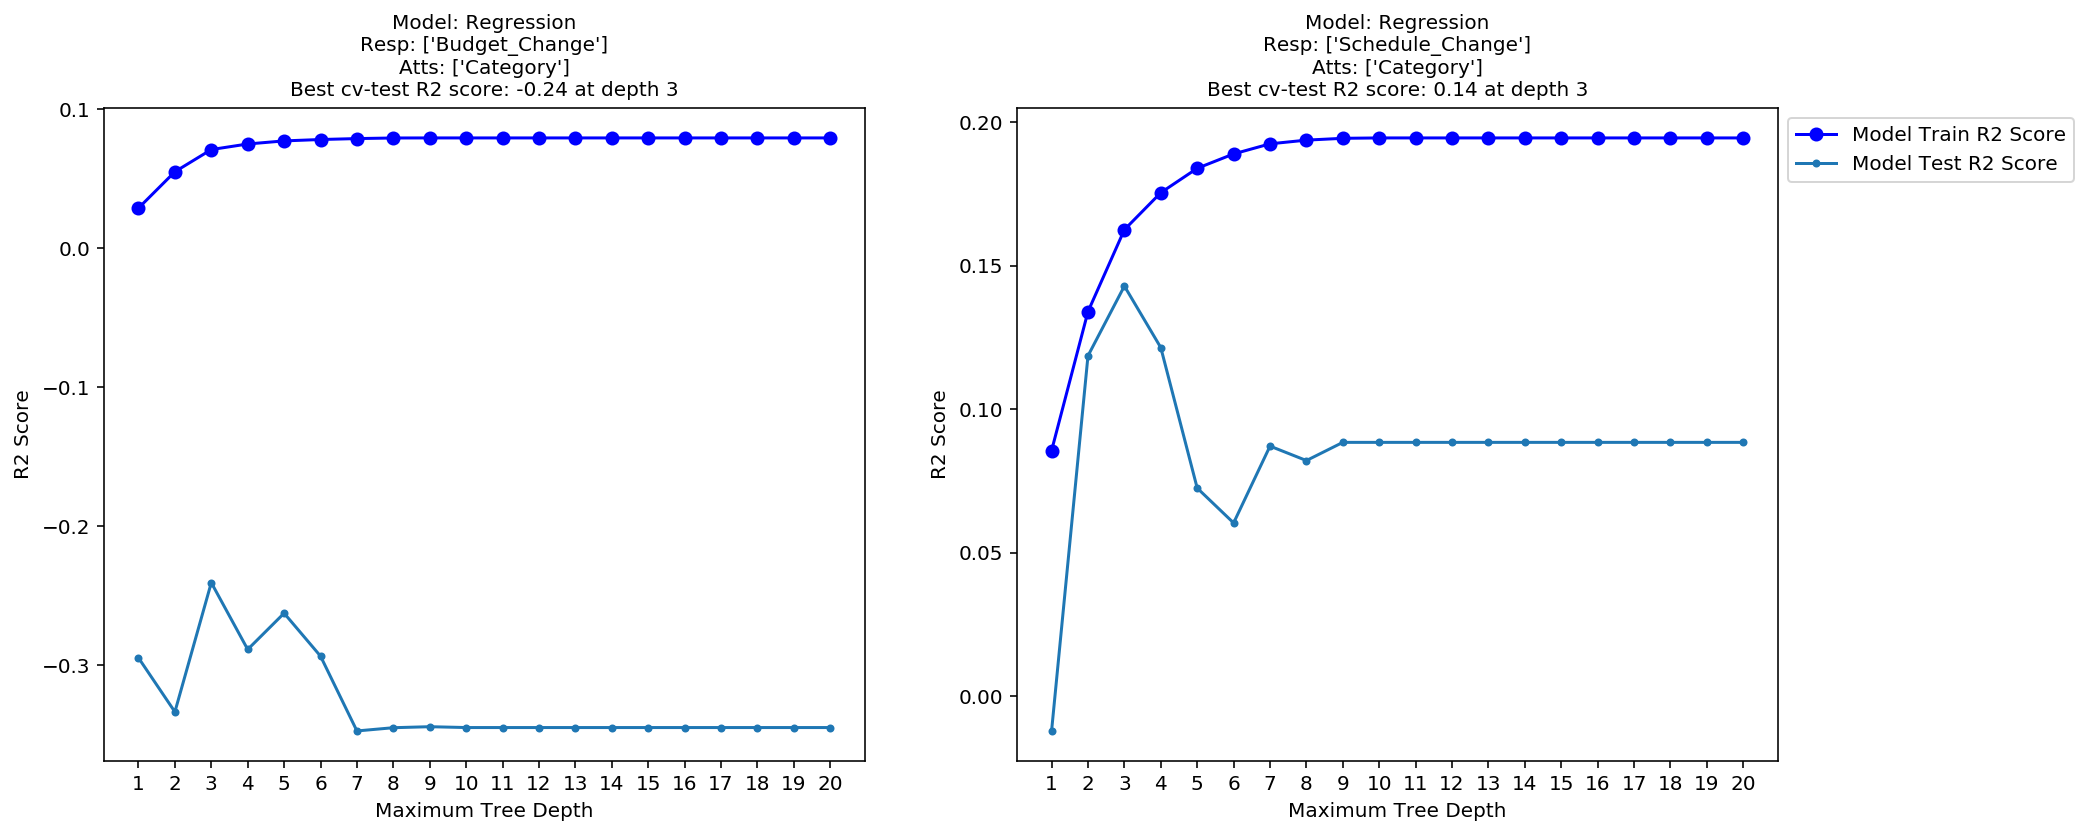

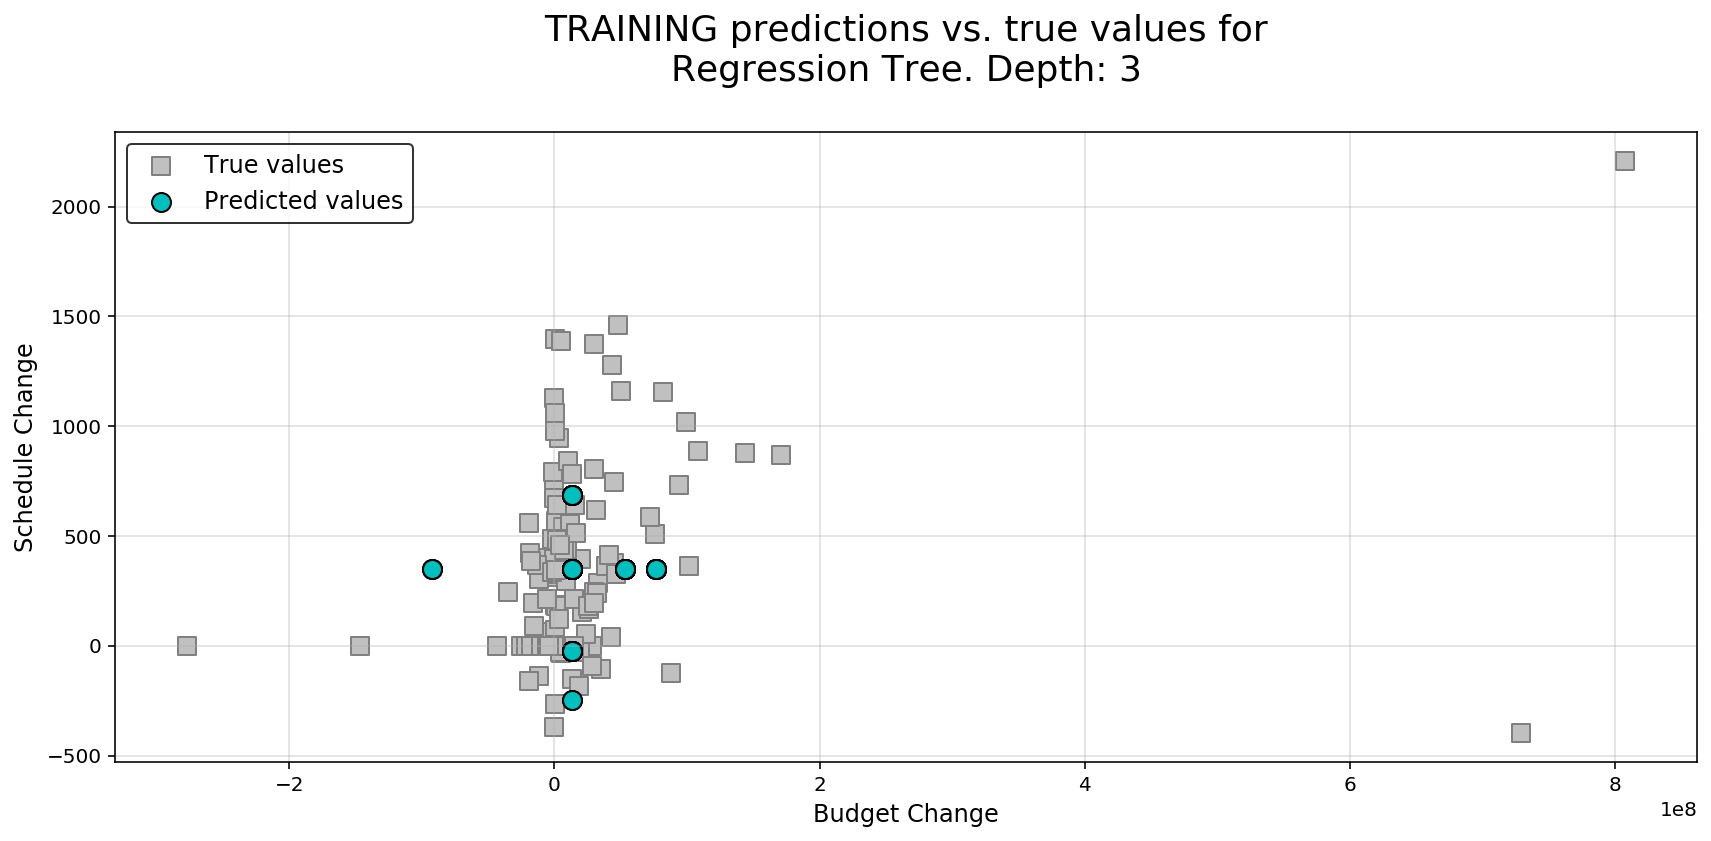

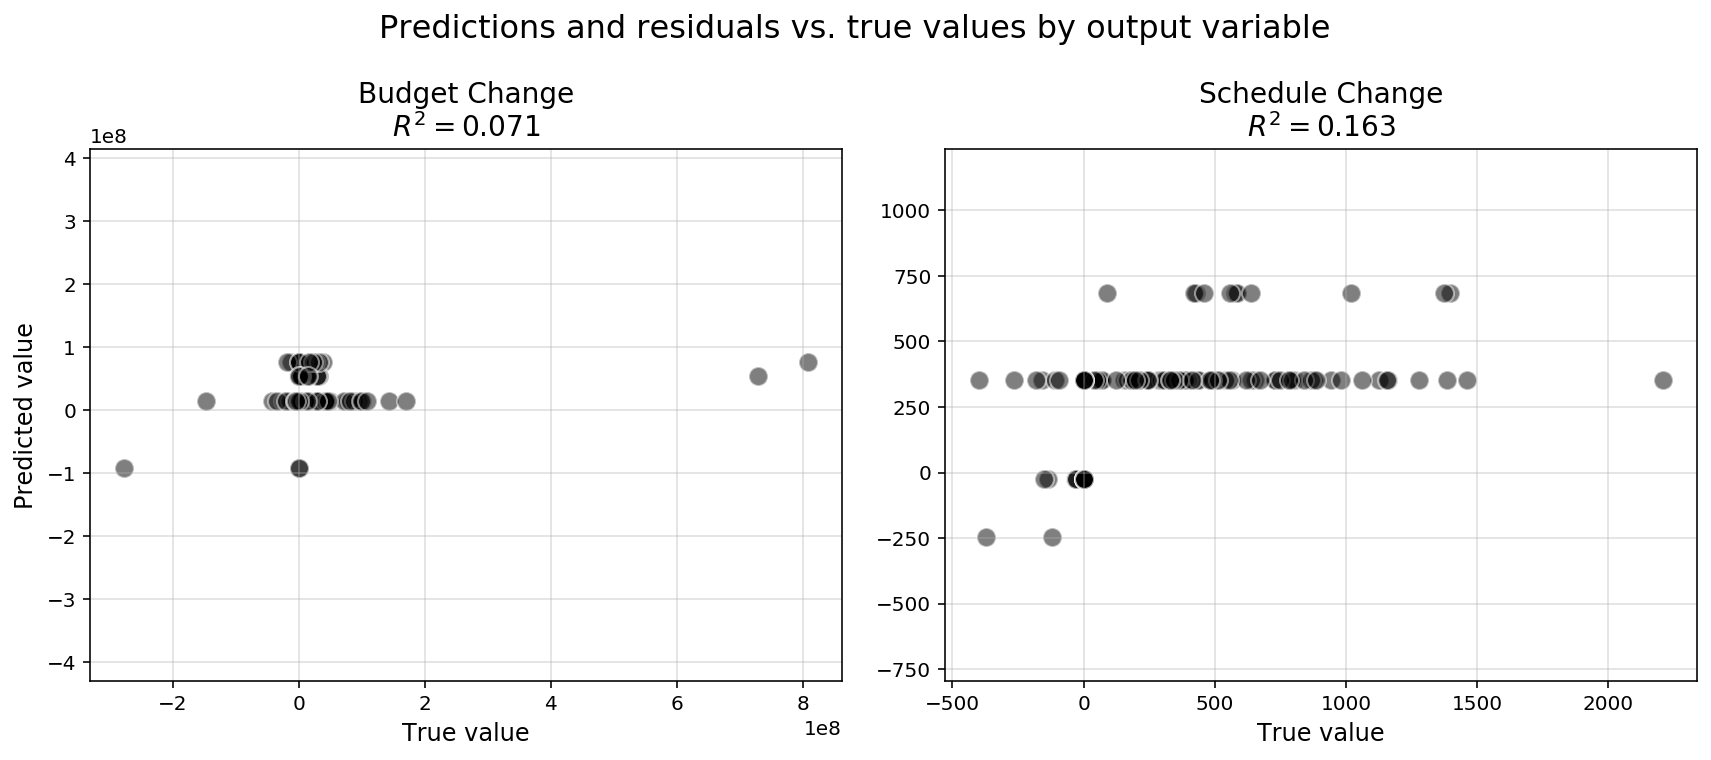

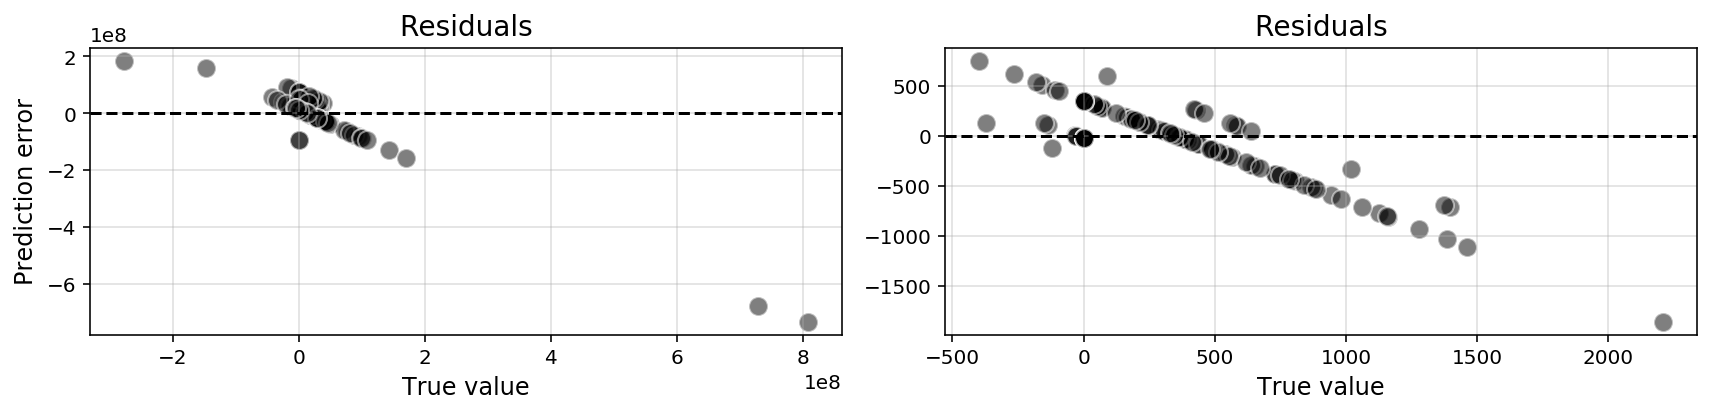

In [46]:
attributes = [  
                    'Category',
#                     'Budget_Start',
#                     'Duration_Start' 
             ]

dummy_columns = [
                    'Category', 
                ]

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

best_cv_score, best_depth, results, model_dict = plot_tree(data, dummy_columns, attributes=attributes, responses_list=responses_list, logistic=logistic)
results_all += results
model_dicts.append(model_dict)


Using Regression Model

MODEL SUMMARY:
Regression Tree. Depth: 3


The fitted model object(s):

	DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

	DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')


This model resulted in the following R-squared scores:

	Budget_Change

		Training	0.6080
		Test		-0.0657

	S

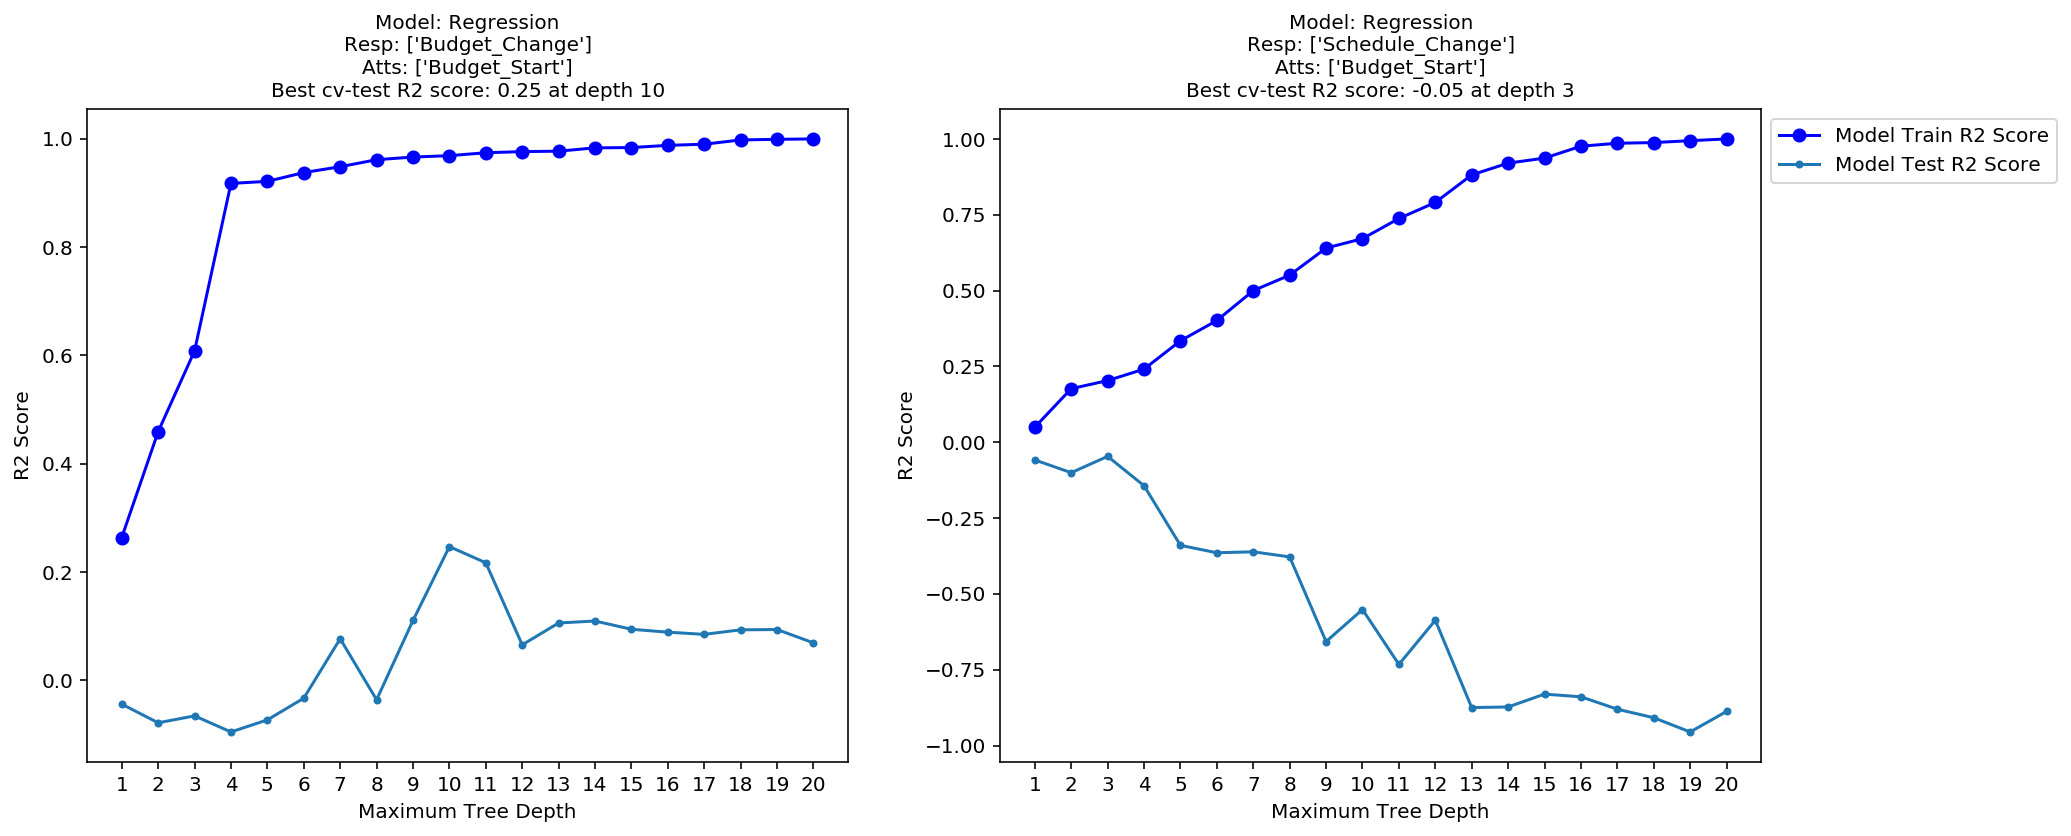

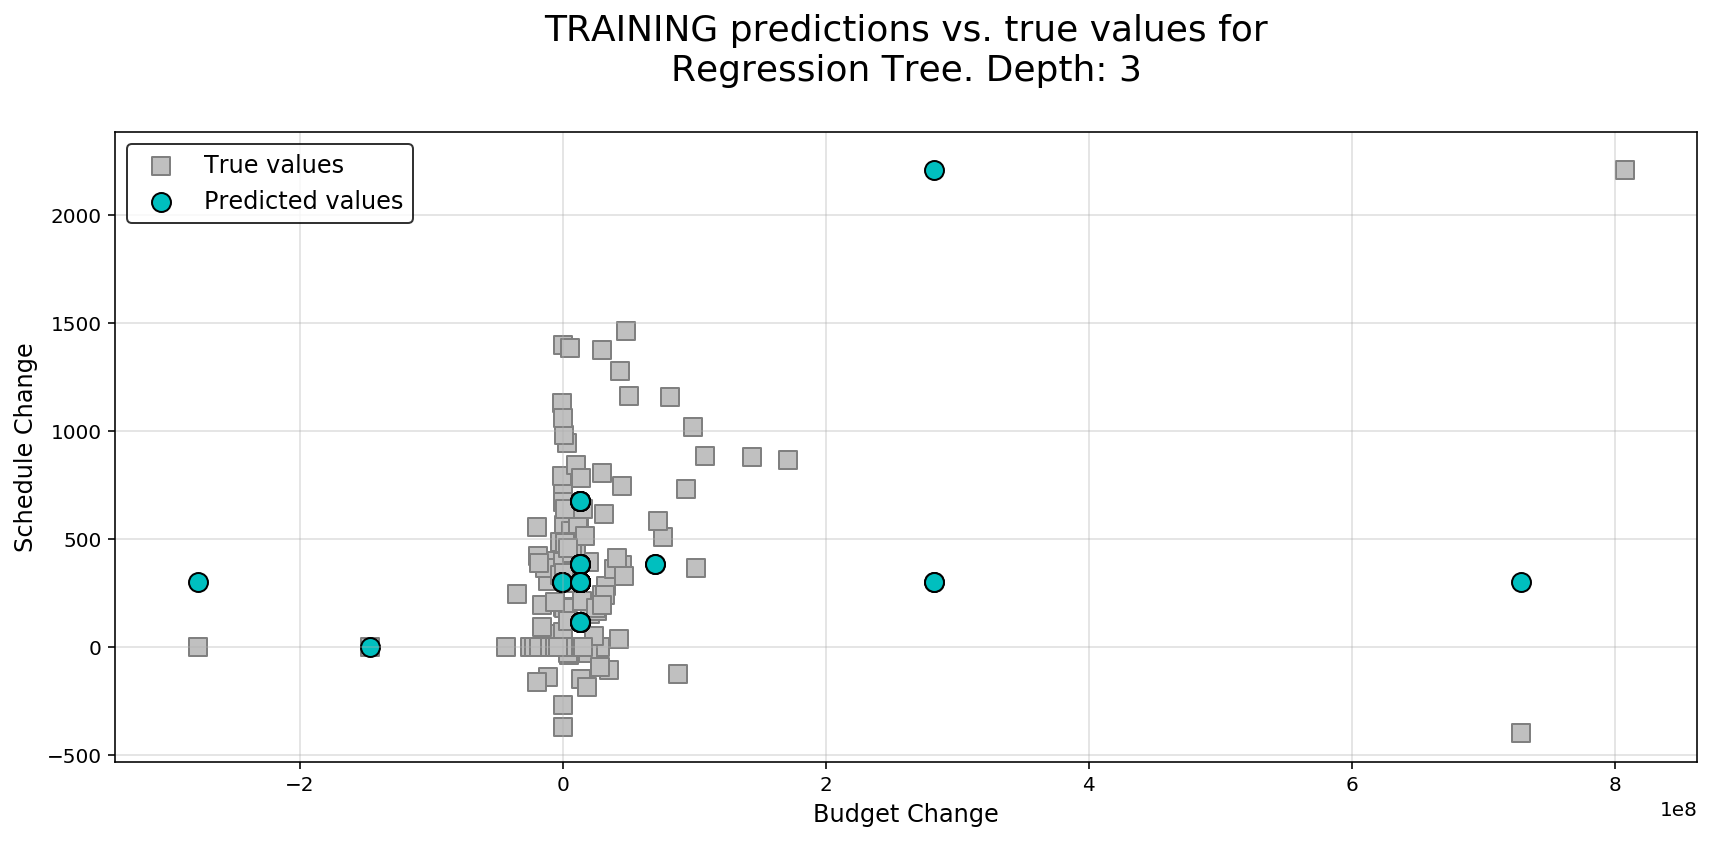

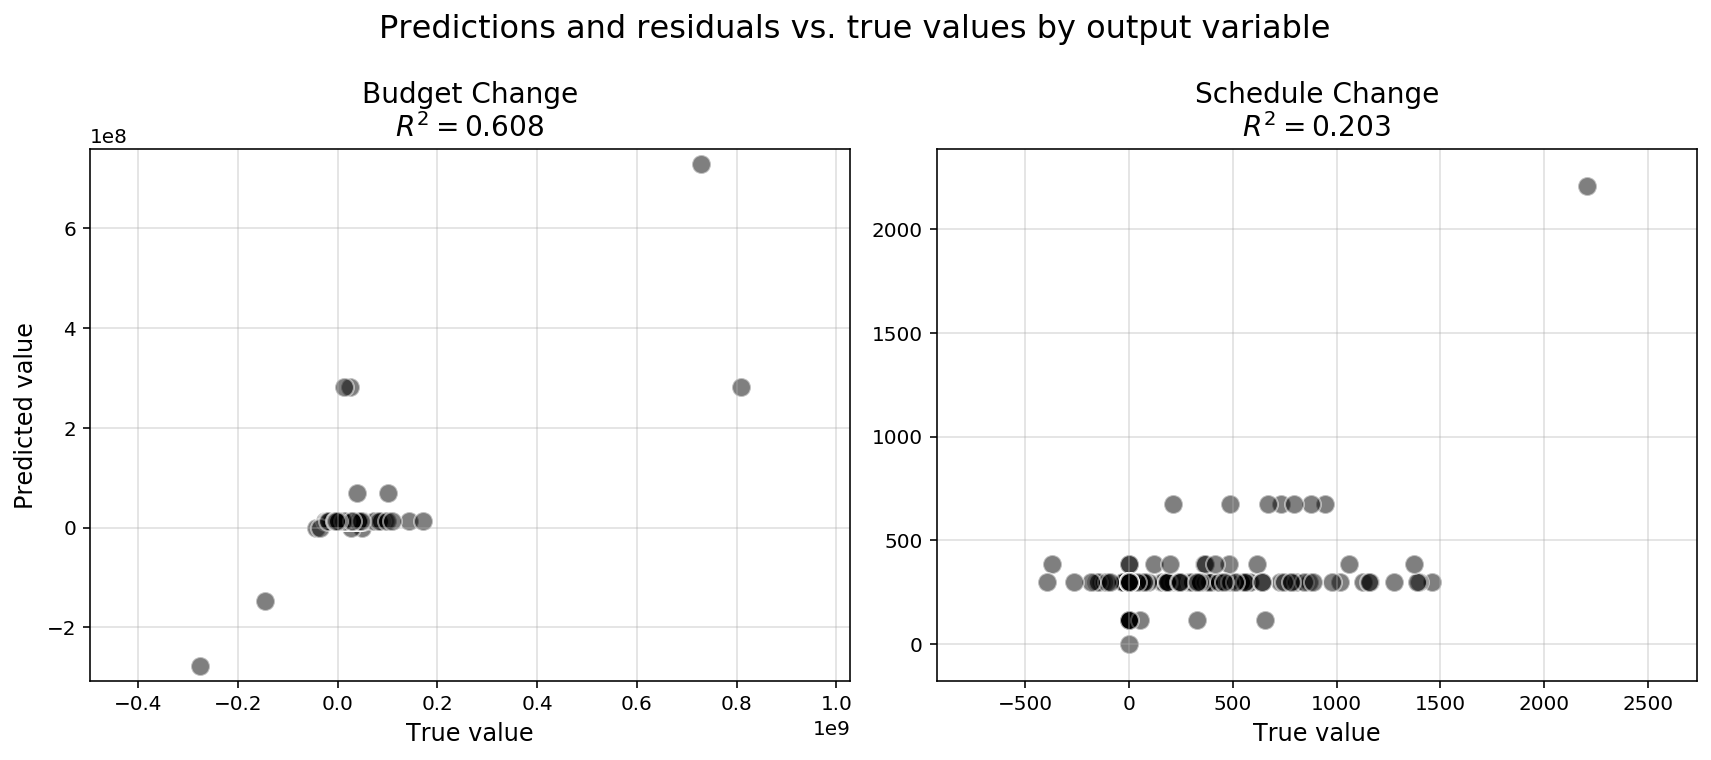

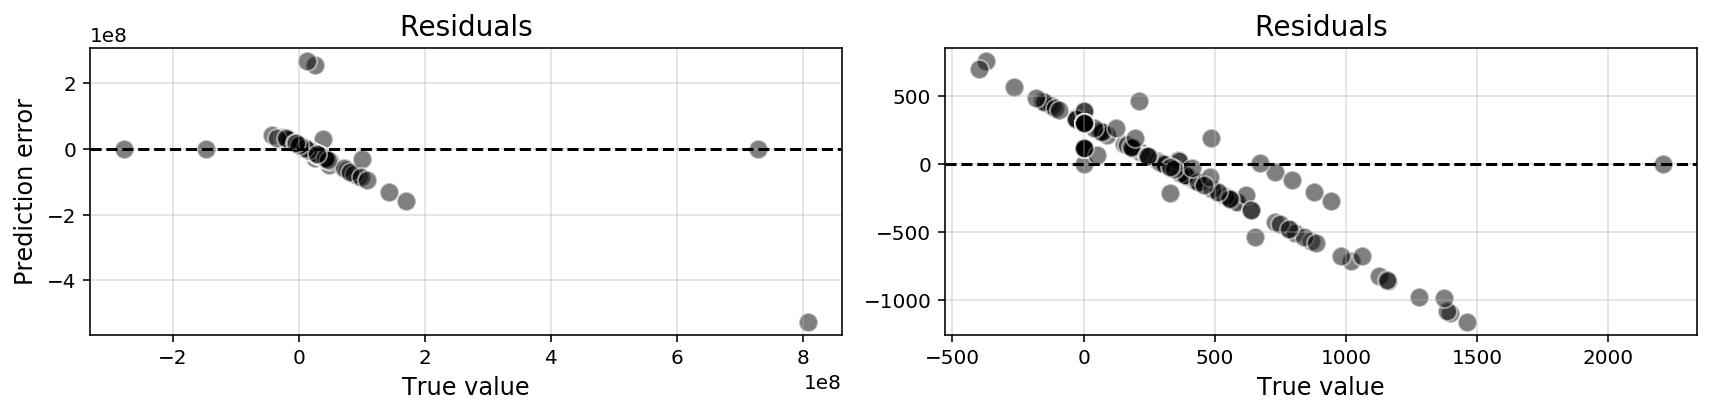

In [47]:
attributes = [  
#                     'Category',
                    'Budget_Start',
#                     'Duration_Start' 
             ]

dummy_columns = [
#                     'Category', 
                ]

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

best_cv_score, best_depth, results, model_dict = plot_tree(data, dummy_columns, attributes=attributes, responses_list=responses_list, logistic=logistic)
results_all += results
model_dicts.append(model_dict)


Using Regression Model

MODEL SUMMARY:
Regression Tree. Depth: 2


The fitted model object(s):

	DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

	DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')


This model resulted in the following R-squared scores:

	Budget_Change

		Training	0.8494
		Test		-26.6808

	

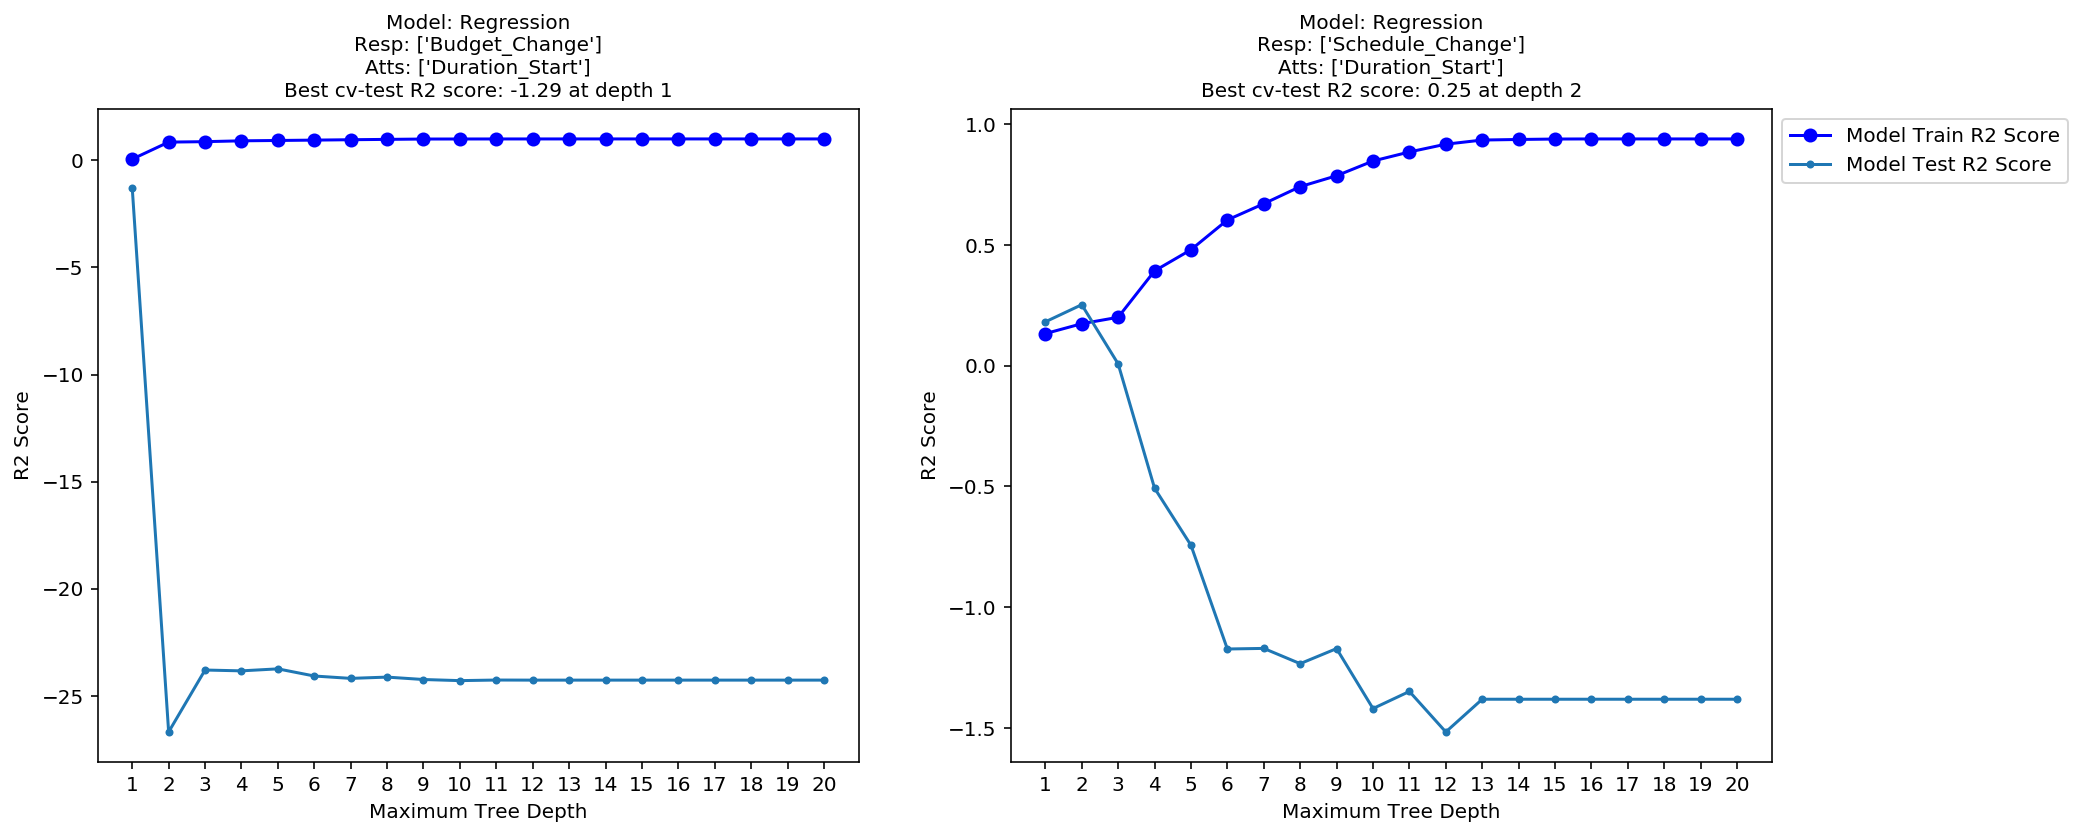

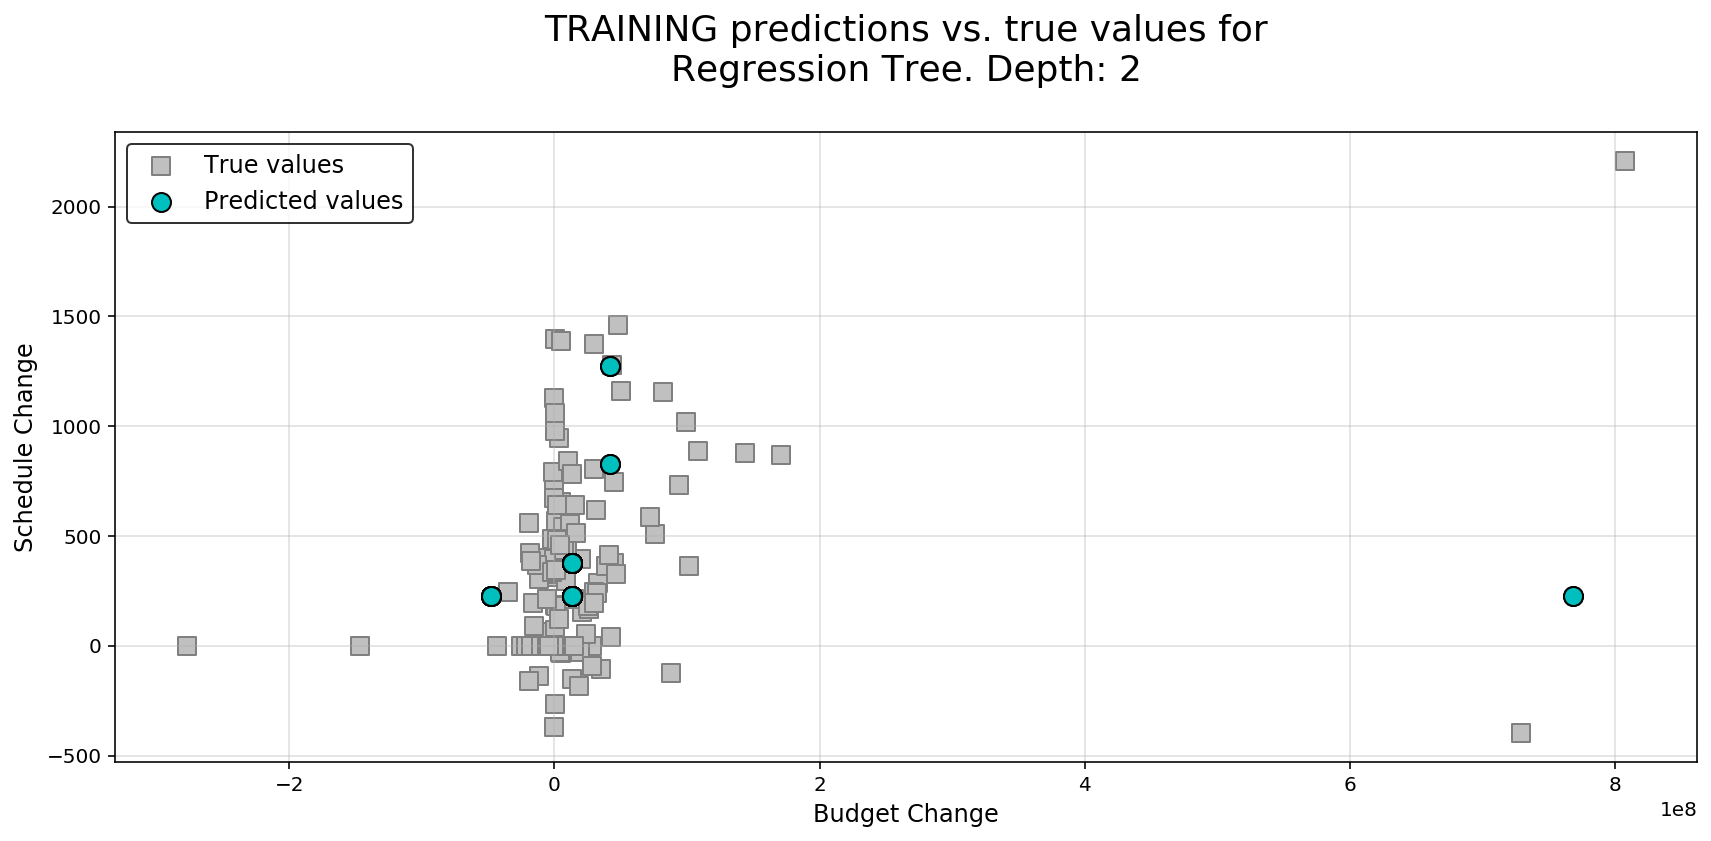

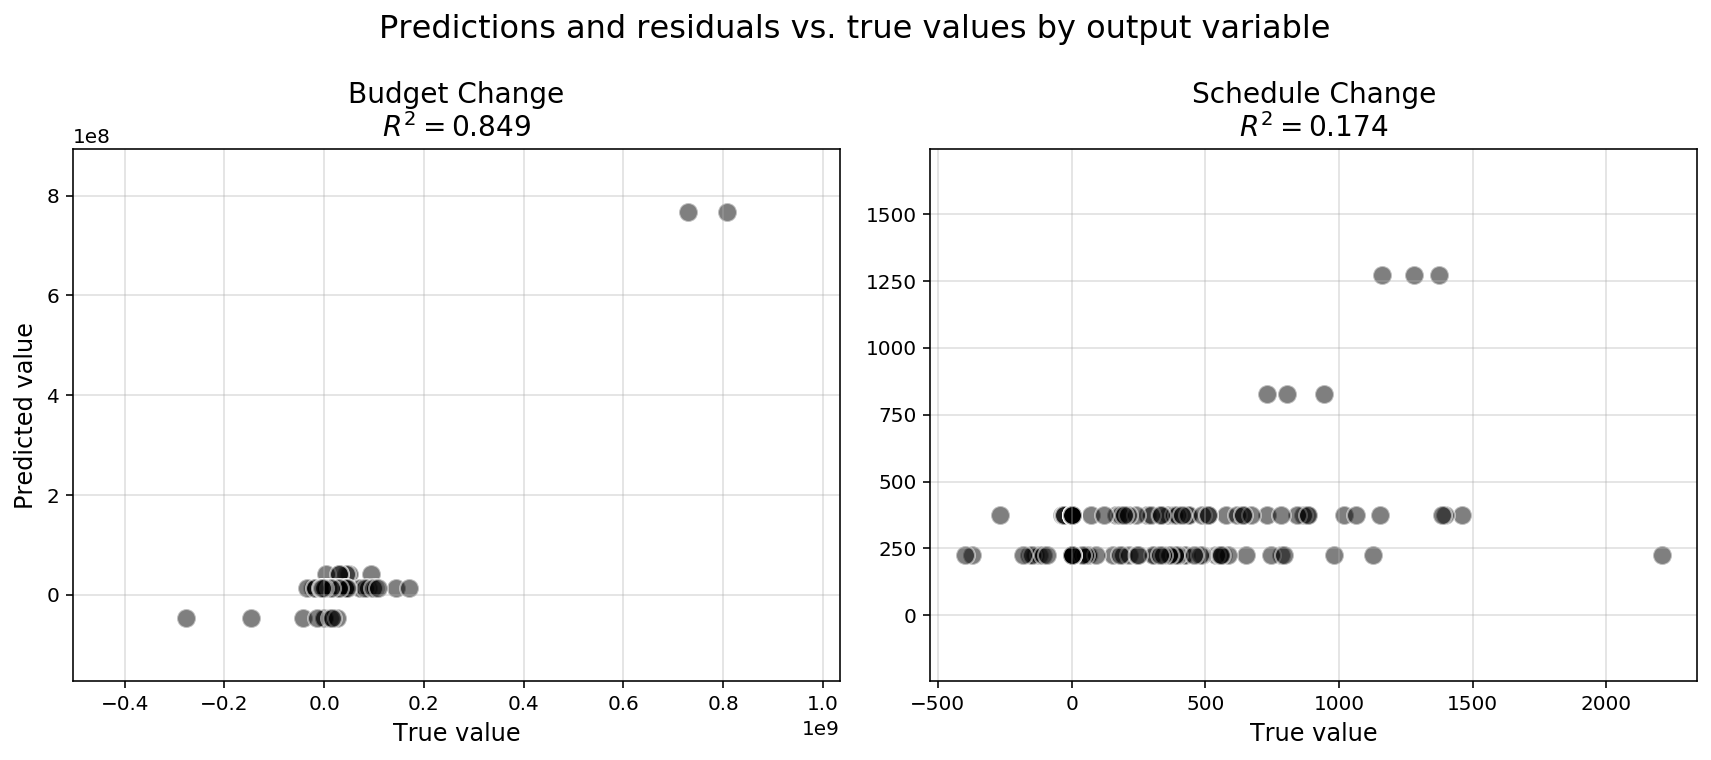

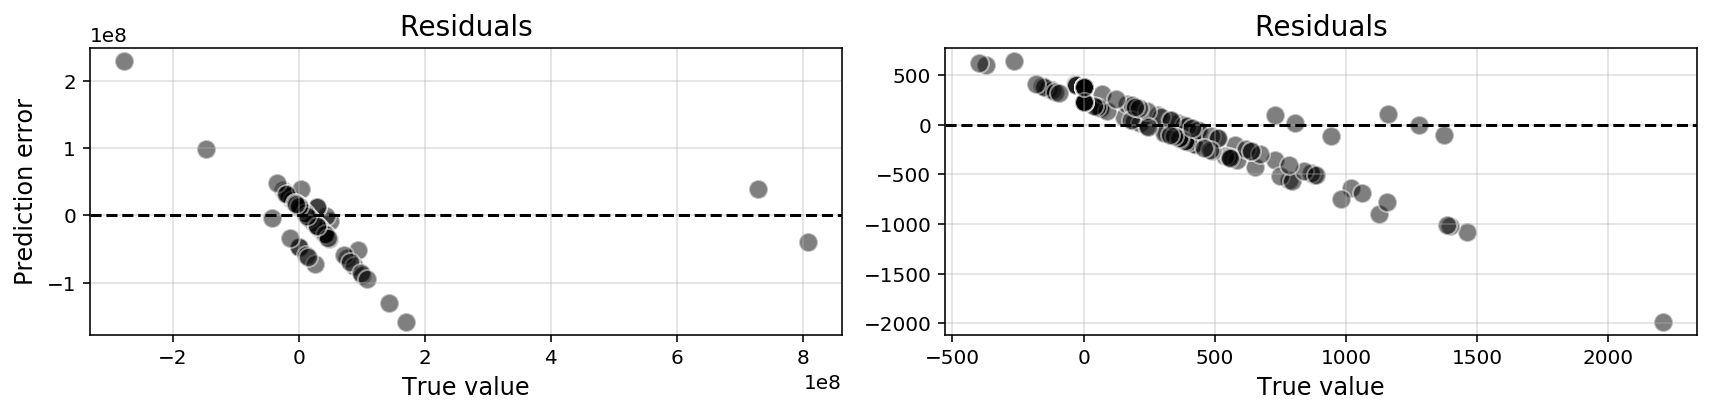

In [48]:
attributes = [  
#                     'Category',
#                     'Budget_Start',
                    'Duration_Start' 
             ]

dummy_columns = [
#                     'Category', 
                ]

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

best_cv_score, best_depth, results, model_dict = plot_tree(data, dummy_columns, attributes=attributes, responses_list=responses_list, logistic=logistic)
results_all += results
model_dicts.append(model_dict)


Using Regression Model

MODEL SUMMARY:
Regression Tree. Depth: 5


The fitted model object(s):

	DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

	DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')


This model resulted in the following R-squared scores:

	Budget_Change

		Training	0.9182
		Test		-0.3128

	S

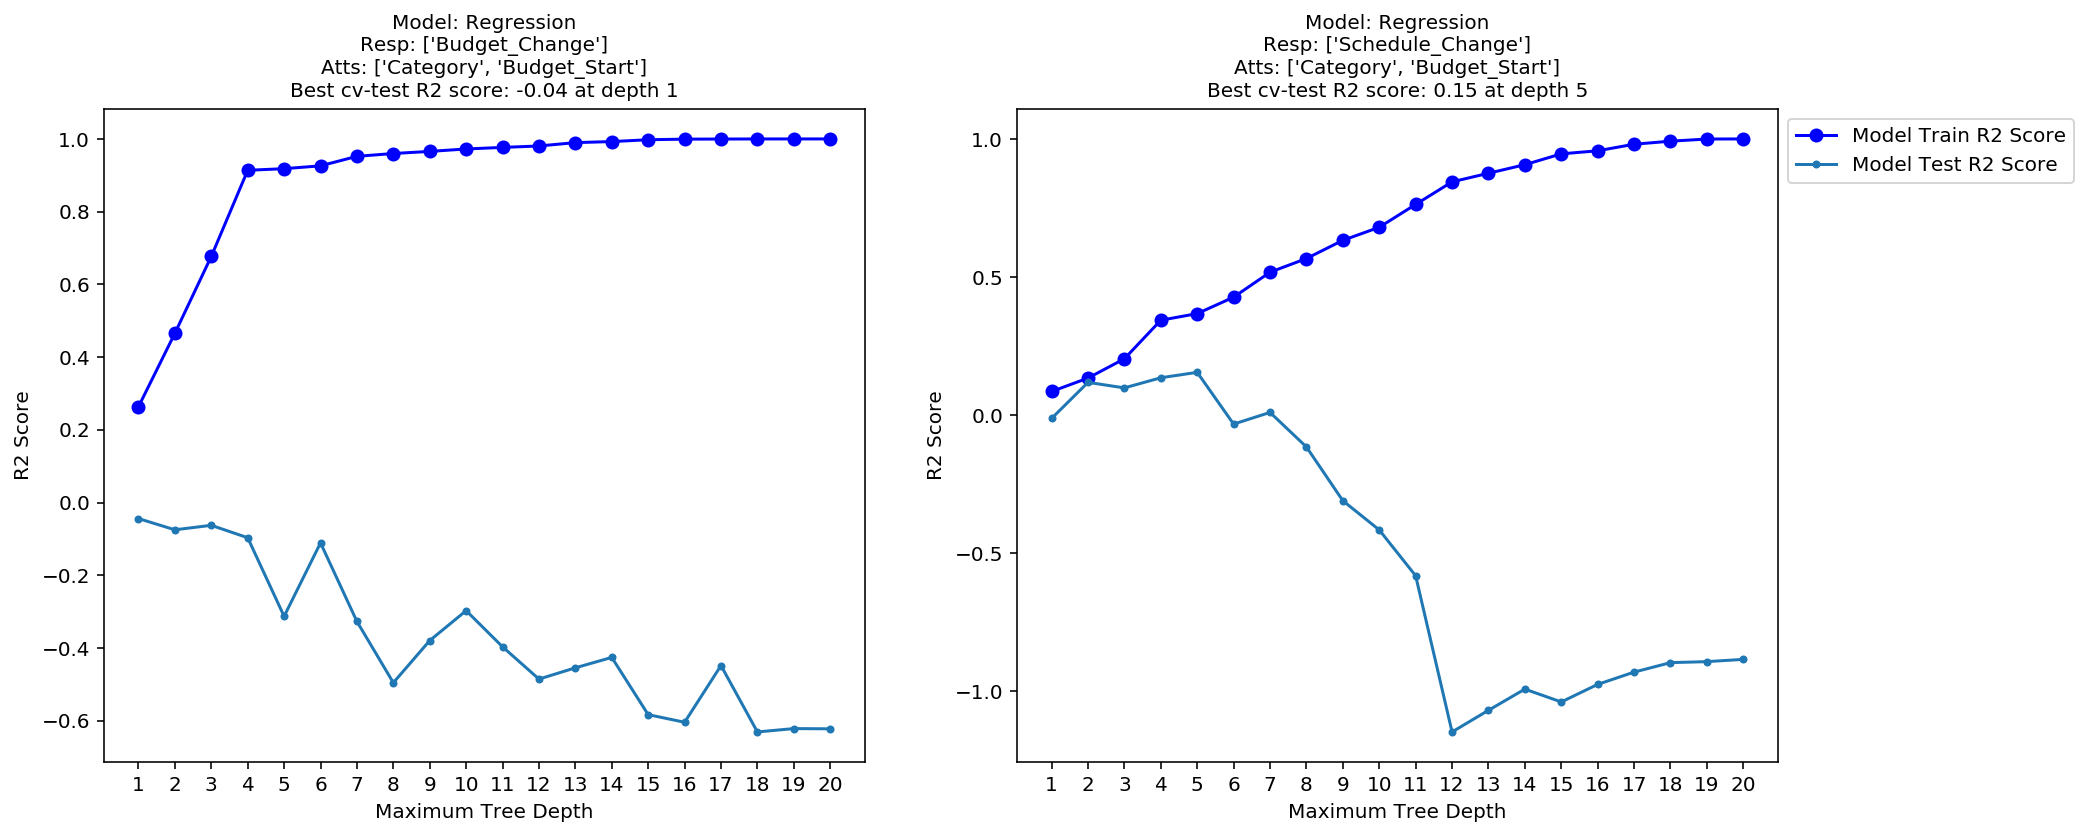

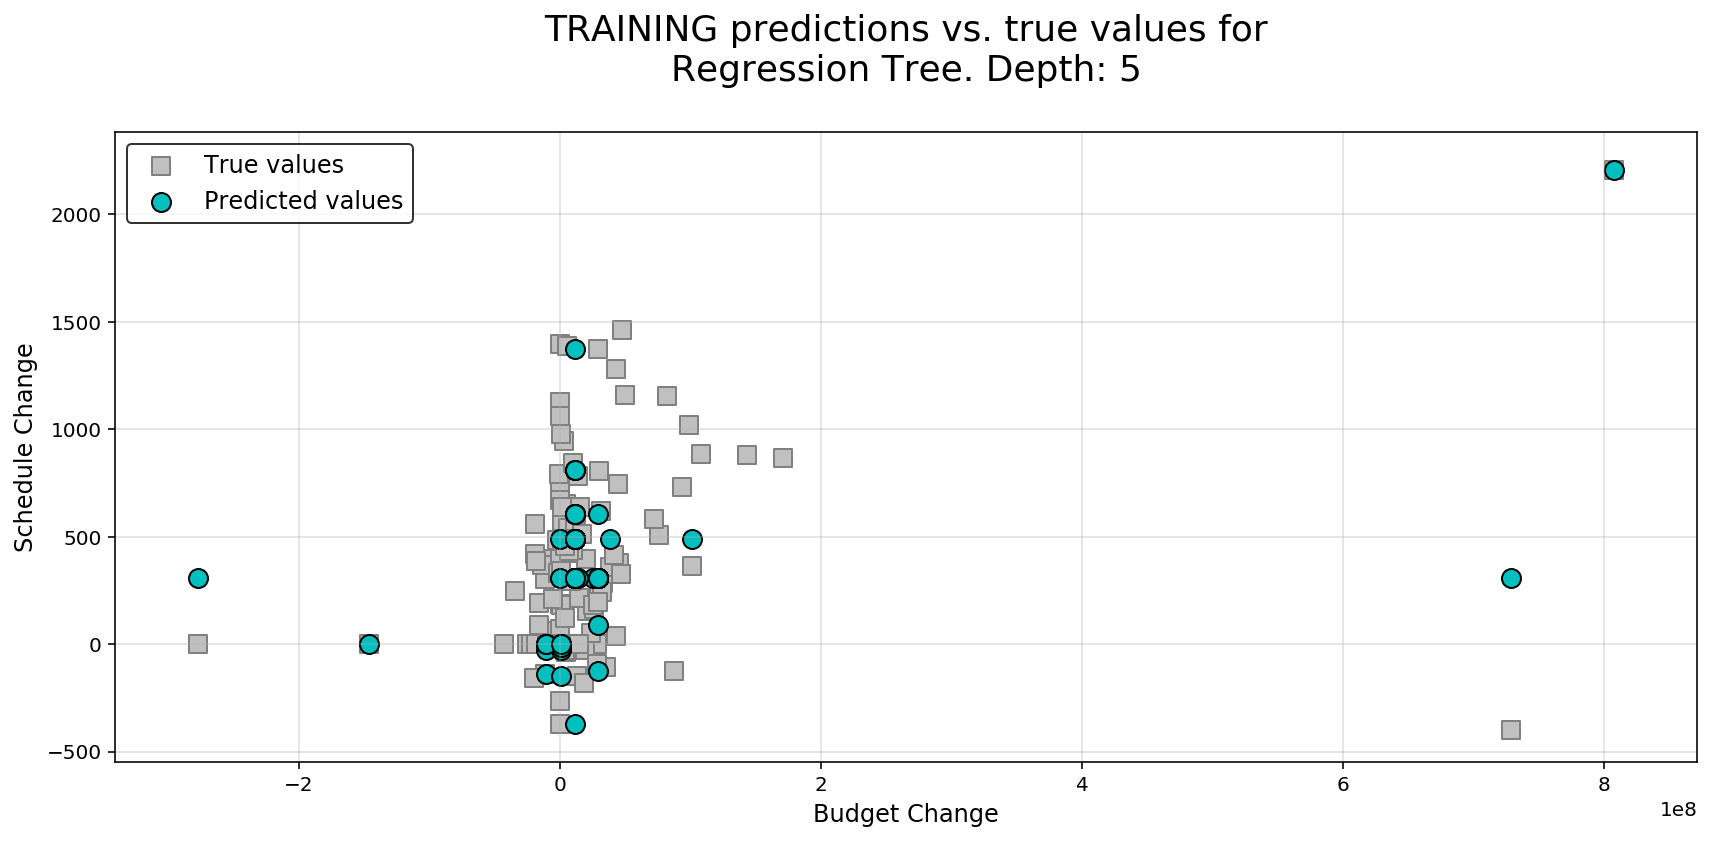

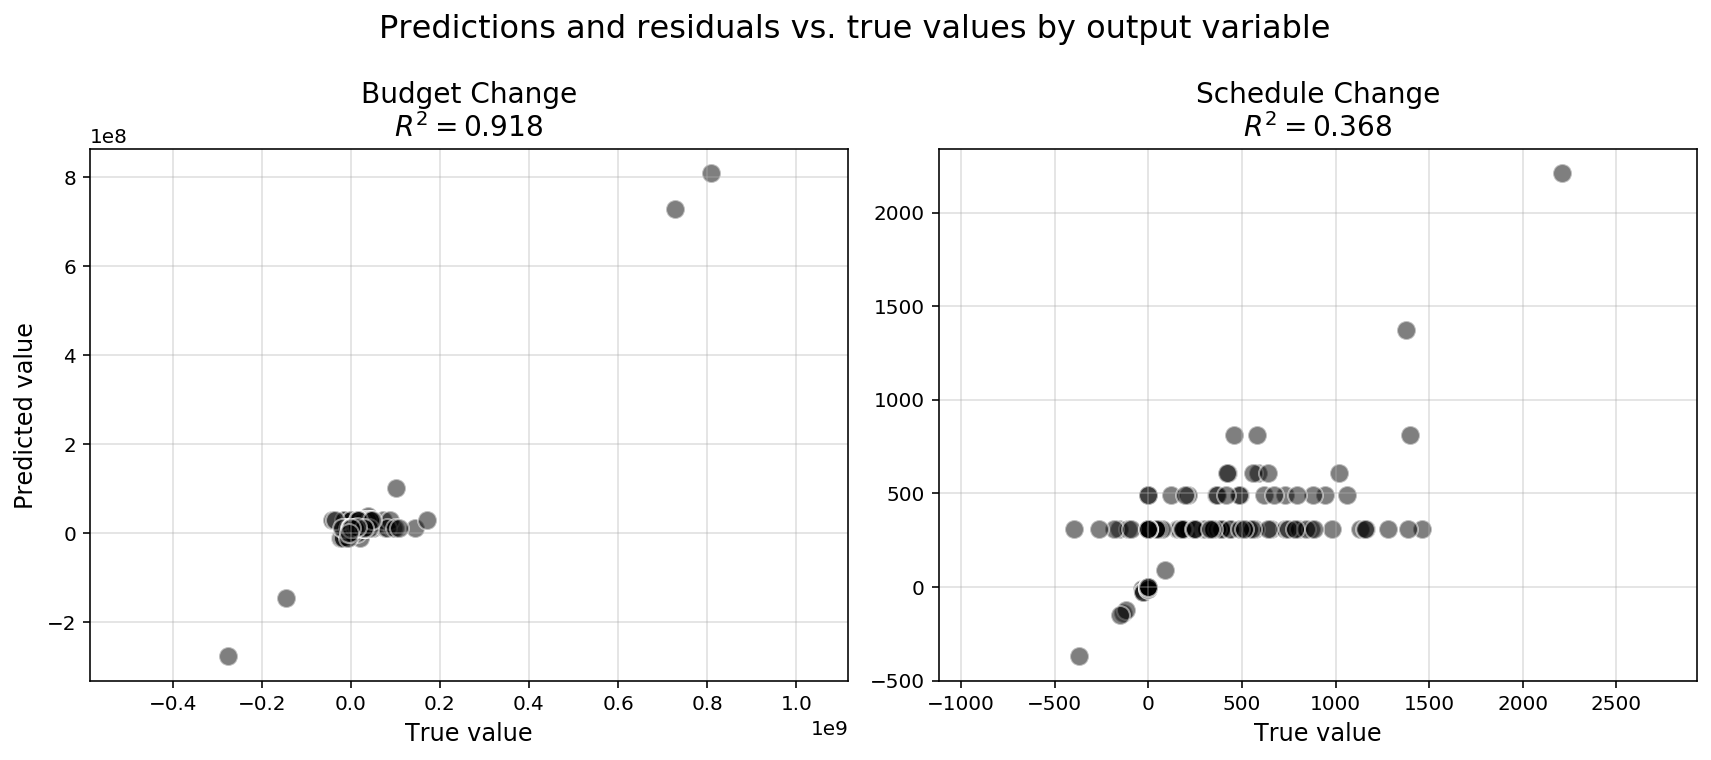

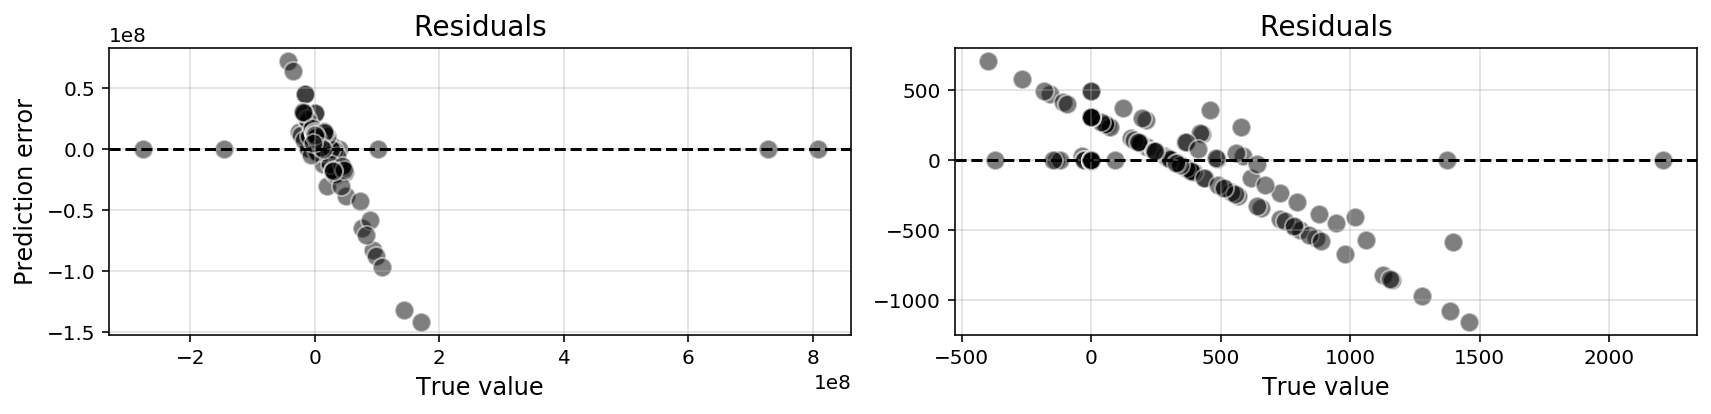

In [49]:
attributes = [  
                    'Category',
                    'Budget_Start',
#                     'Duration_Start' 
             ]

dummy_columns = [
                    'Category', 
                ]

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

best_cv_score, best_depth, results, model_dict = plot_tree(data, dummy_columns, attributes=attributes, responses_list=responses_list, logistic=logistic)
results_all += results
model_dicts.append(model_dict)


Using Regression Model

MODEL SUMMARY:
Regression Tree. Depth: 5


The fitted model object(s):

	DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

	DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')


This model resulted in the following R-squared scores:

	Budget_Change

		Training	0.9300
		Test		-30.1437

	

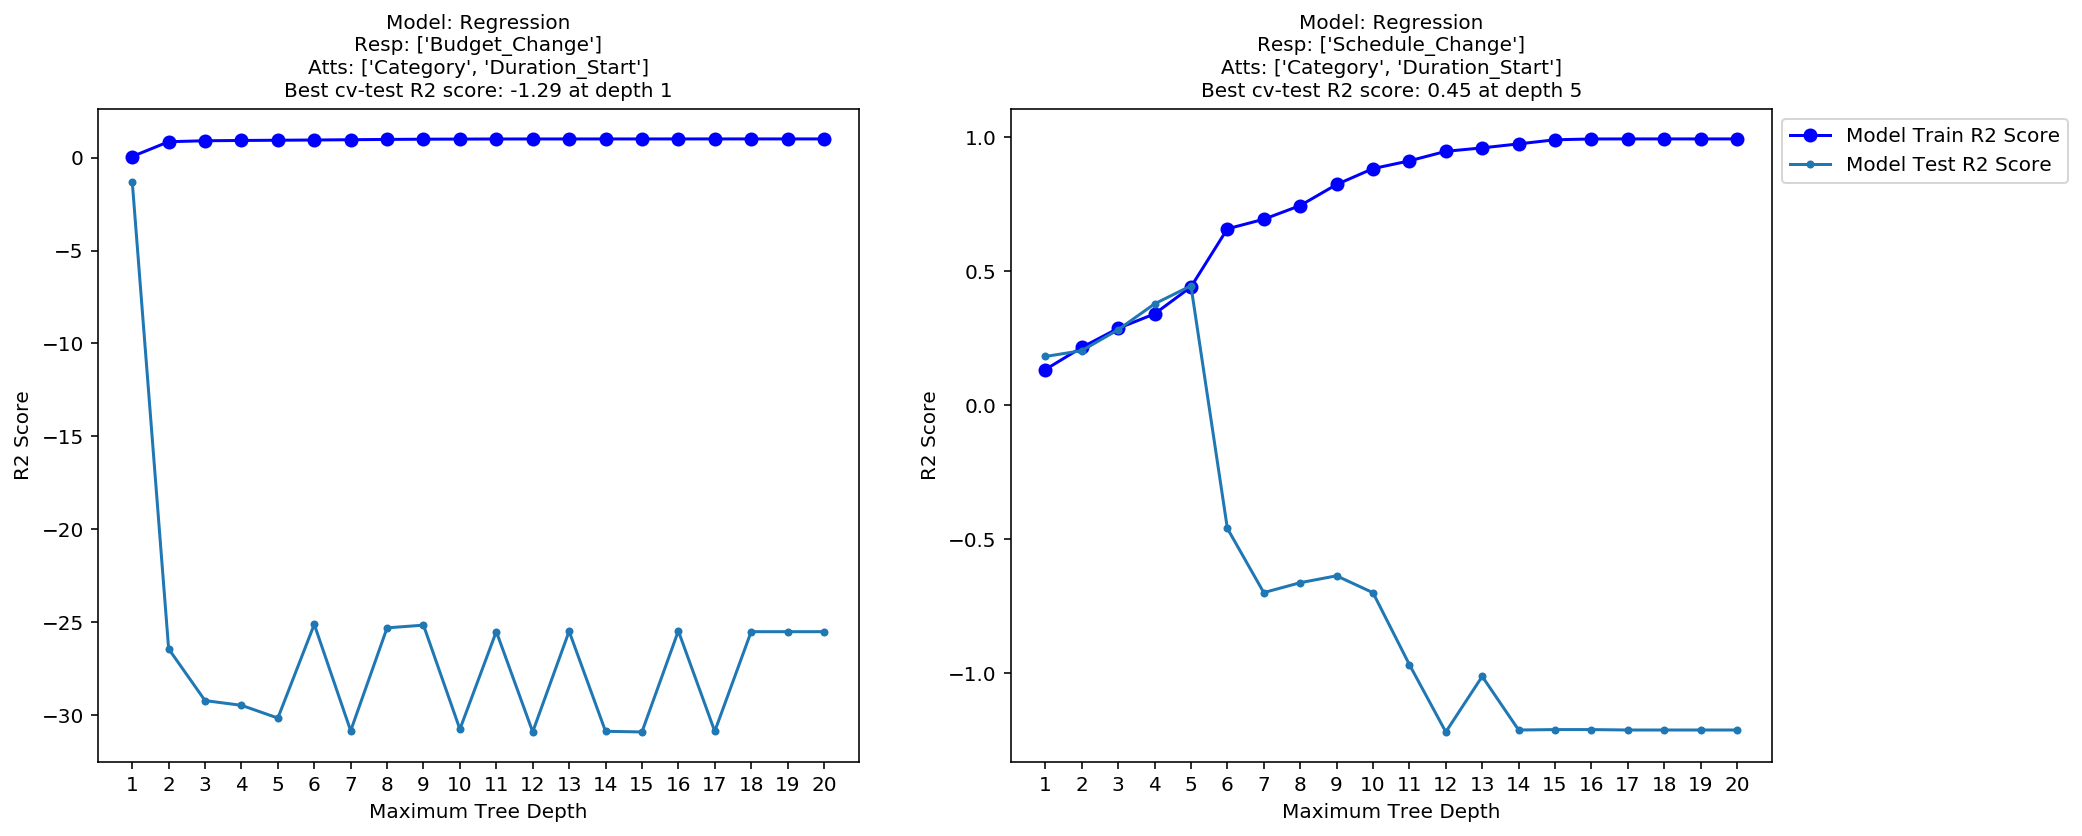

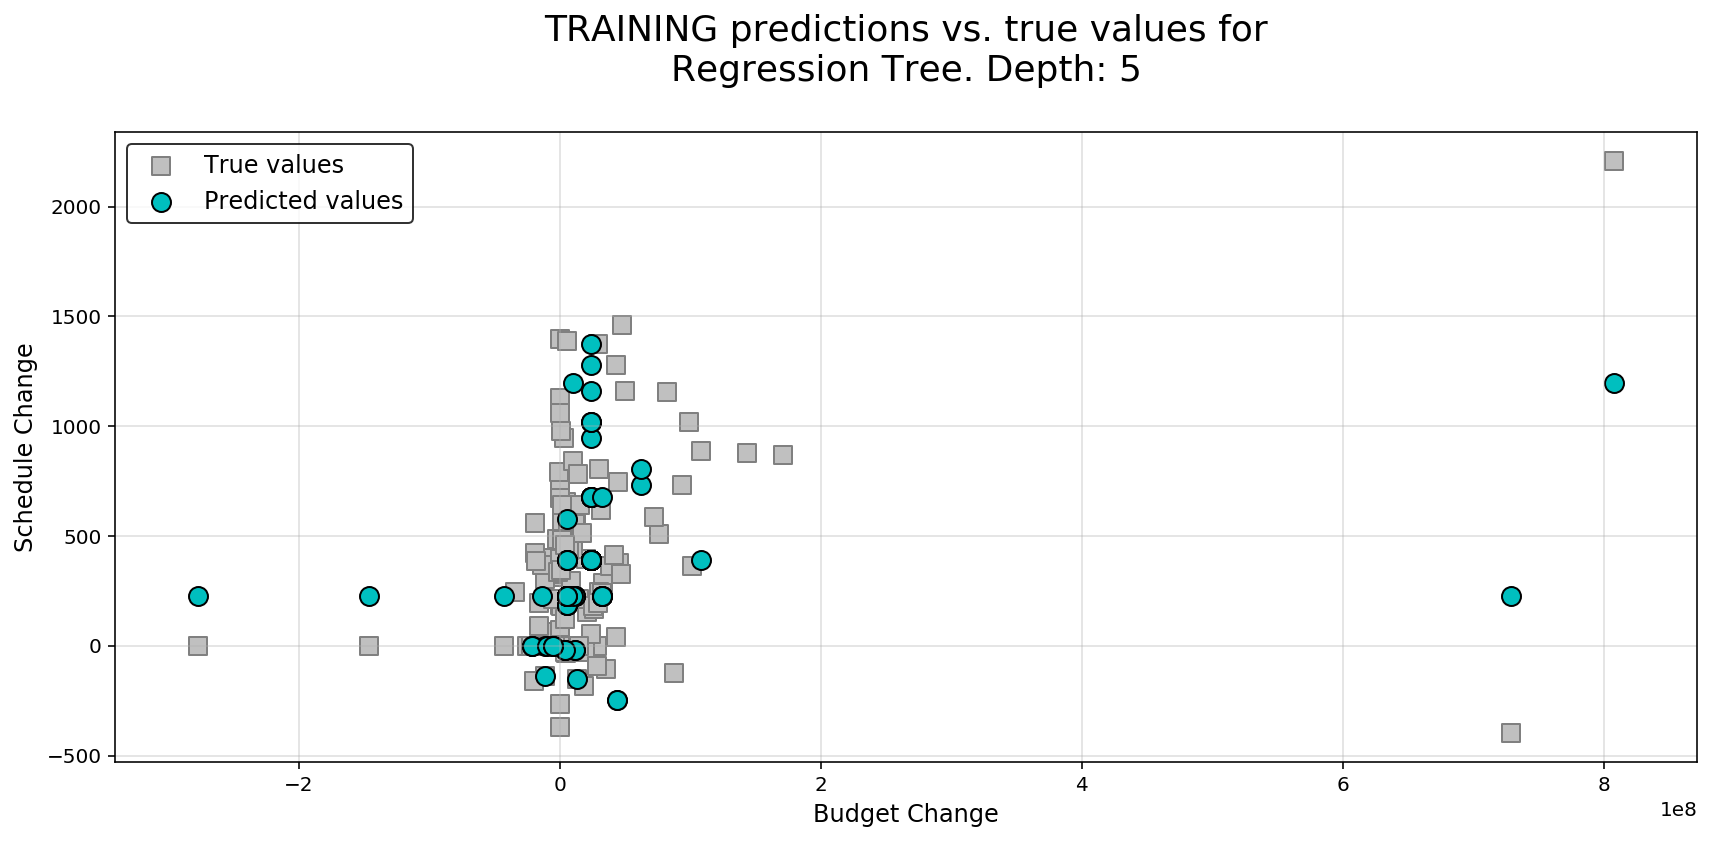

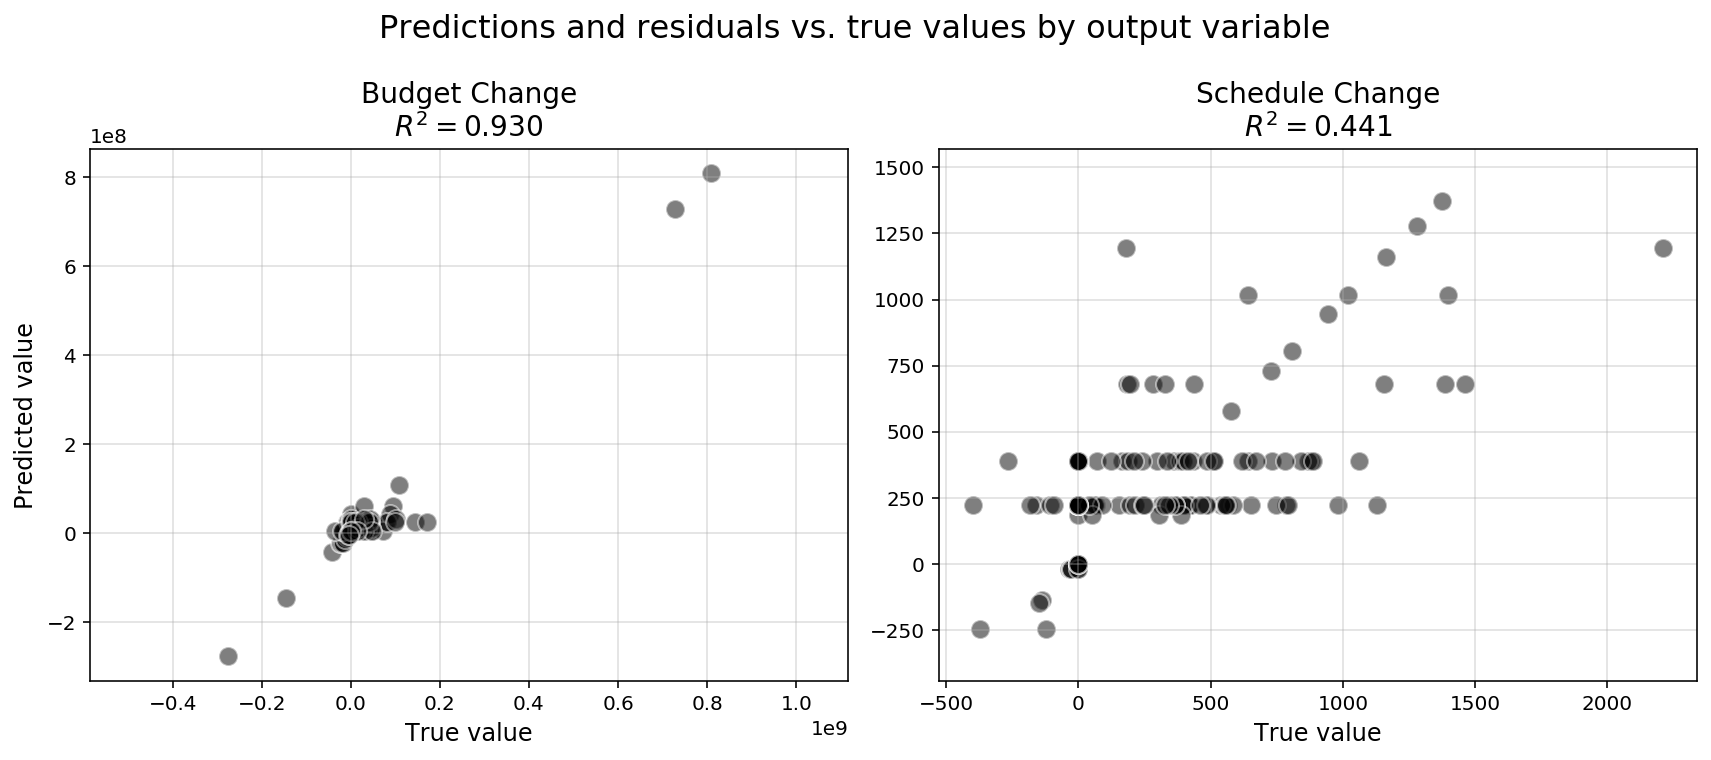

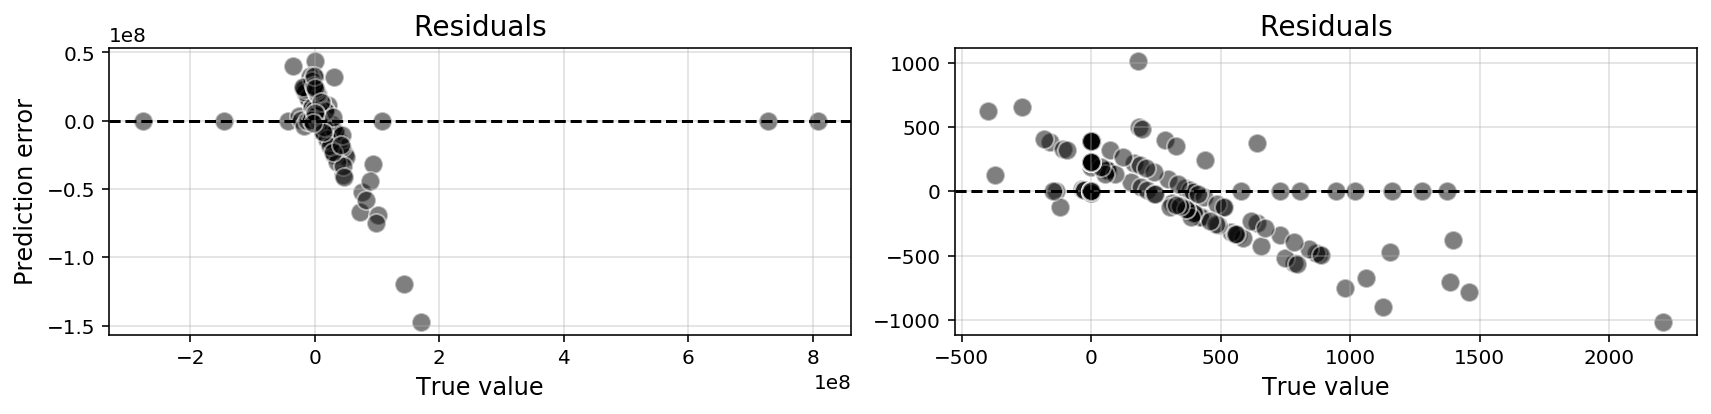

In [50]:
attributes = [  
                    'Category',
#                     'Budget_Start',
                    'Duration_Start' 
             ]

dummy_columns = [
                    'Category', 
                ]

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

best_cv_score, best_depth, results, model_dict = plot_tree(data, dummy_columns, attributes=attributes, responses_list=responses_list, logistic=logistic)
results_all += results
model_dicts.append(model_dict)


Using Regression Model

MODEL SUMMARY:
Regression Tree. Depth: 3


The fitted model object(s):

	DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

	DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')


This model resulted in the following R-squared scores:

	Budget_Change

		Training	0.8835
		Test		-0.7721

	S

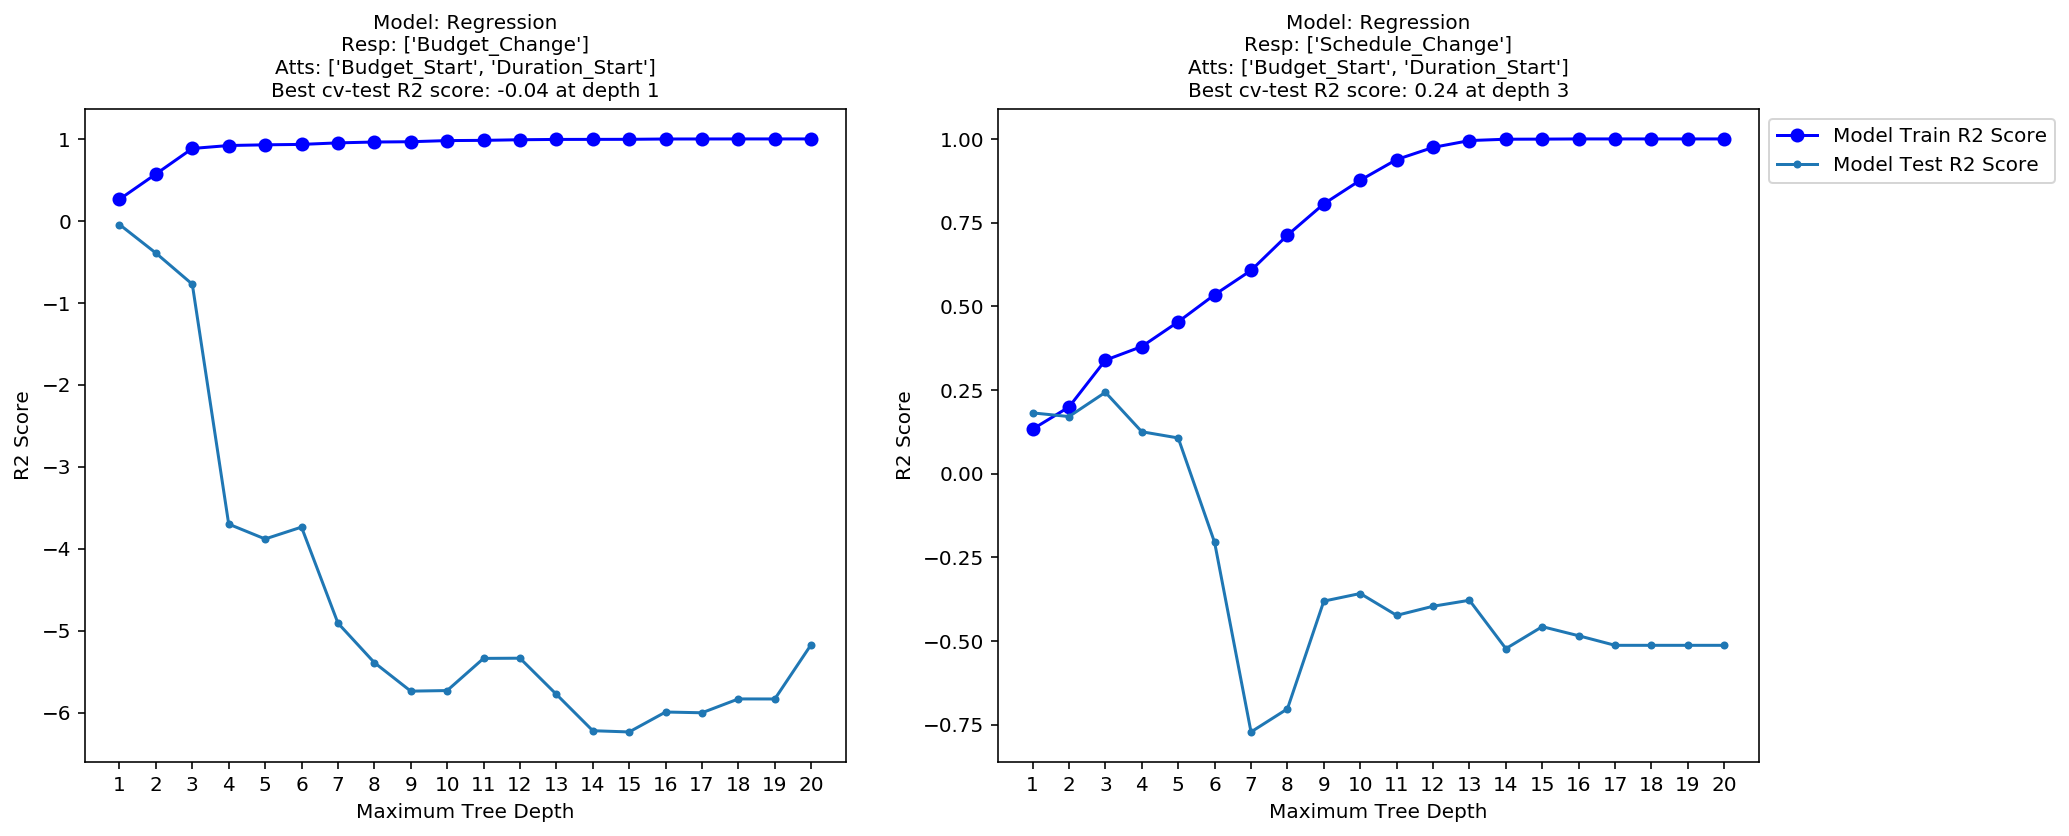

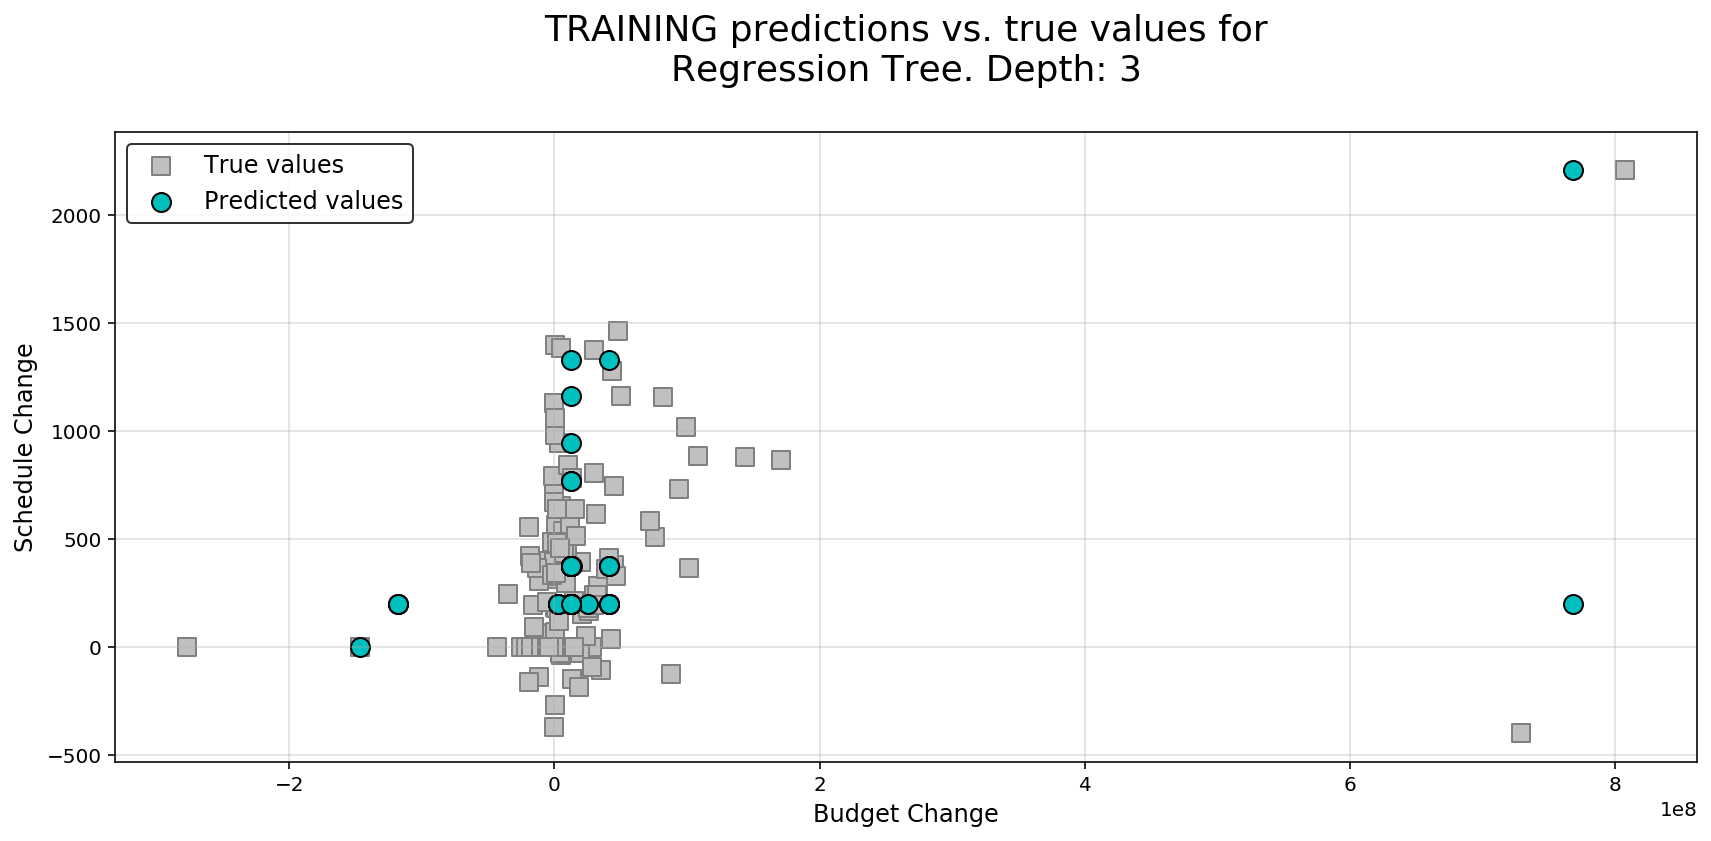

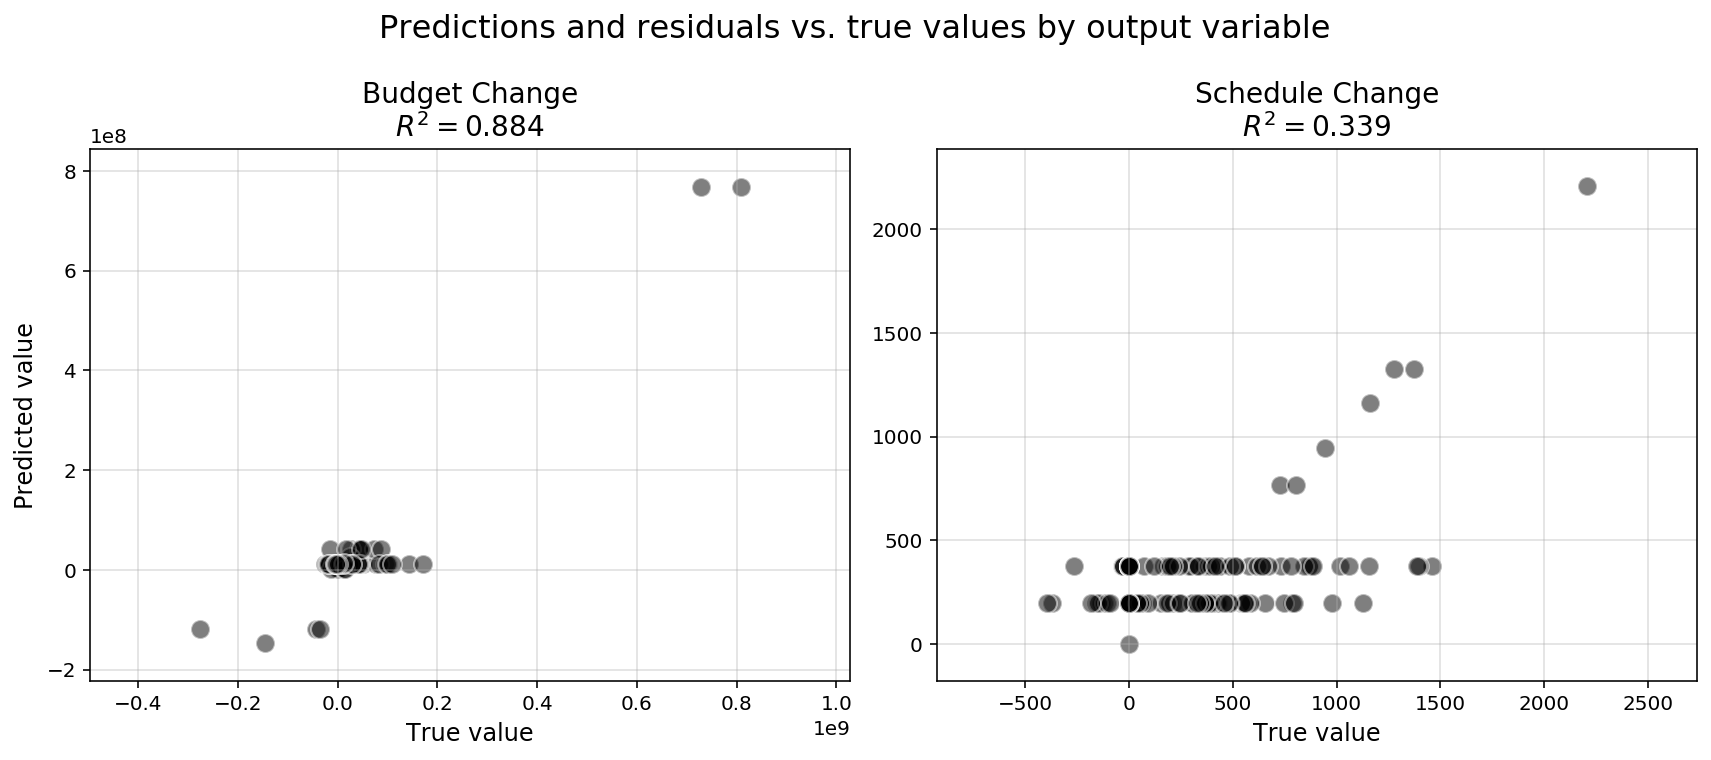

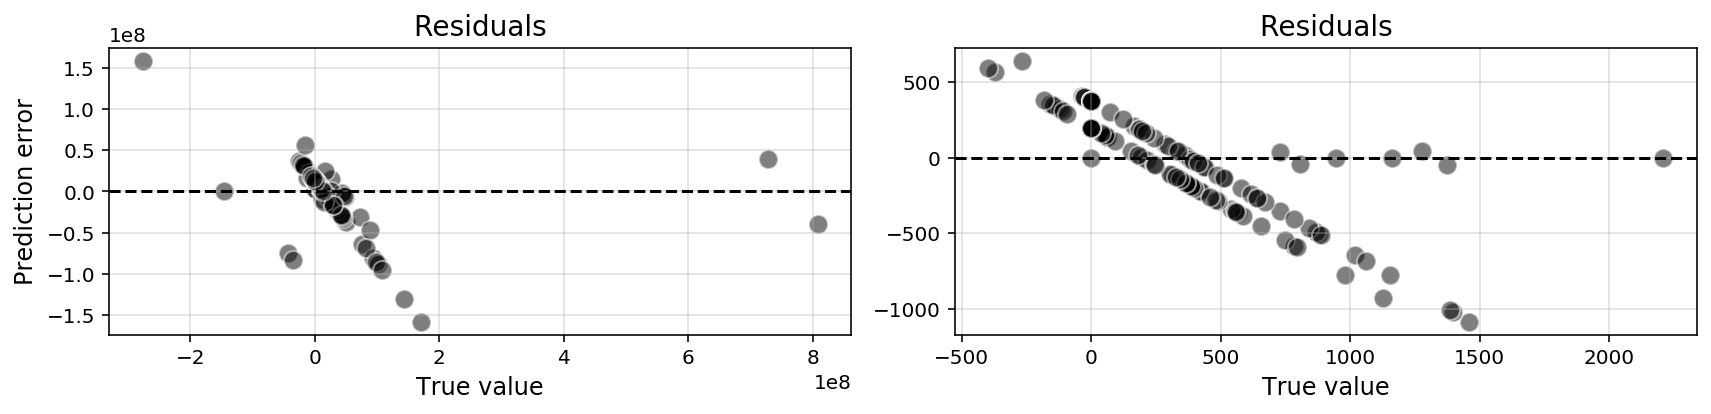

In [51]:
attributes = [  
#                     'Category',
                    'Budget_Start',
                    'Duration_Start' 
             ]

dummy_columns = [
#                     'Category', 
                ]

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

best_cv_score, best_depth, results, model_dict = plot_tree(data, dummy_columns, attributes=attributes, responses_list=responses_list, logistic=logistic)
results_all += results
model_dicts.append(model_dict)


In [52]:
results_df = pd.DataFrame(results_all)
results_df[results_df['best_depth'] == 1]

attributes        responses  best_cv_score  \
0   [Category, Budget_Start, Duration_Start]  [Budget_Change]          -0.04   
6                           [Duration_Start]  [Budget_Change]          -1.29   
8                   [Category, Budget_Start]  [Budget_Change]          -0.04   
10                [Category, Duration_Start]  [Budget_Change]          -1.29   
12            [Budget_Start, Duration_Start]  [Budget_Change]          -0.04   

    best_depth  train_score  test_score  \
0            1         0.26       -0.04   
6            1         0.05       -1.29   
8            1         0.26       -0.04   
10           1         0.05       -1.29   
12           1         0.26       -0.04   

                                           best_model  \
0   DecisionTreeRegressor(ccp_alpha=0.0, criterion...   
6   DecisionTreeRegressor(ccp_alpha=0.0, criterion...   
8   DecisionTreeRegressor(ccp_alpha=0.0, criterion...   
10  DecisionTreeRegressor(ccp_alpha=0.0, criterion...   
12  DecisionTreeRegressor(ccp_alpha=0.0, criterion...   

                                         dummies_dict  
0   {'Category': ['Sewers', 'Streets_and_Roadways'...  
6                                                  {}  
8   {'Category': ['Sewers', 'Streets_and_Roadways'...  
10  {'Category': ['Sewers', 'Streets_and_Roadways'...  
12                                                 {}

In [53]:
results_df[results_df['best_depth'] != 1].sort_values(by='test_score')

attributes          responses  \
2                                 [Category]    [Budget_Change]   
5                             [Budget_Start]  [Schedule_Change]   
3                                 [Category]  [Schedule_Change]   
9                   [Category, Budget_Start]  [Schedule_Change]   
13            [Budget_Start, Duration_Start]  [Schedule_Change]   
4                             [Budget_Start]    [Budget_Change]   
7                           [Duration_Start]  [Schedule_Change]   
1   [Category, Budget_Start, Duration_Start]  [Schedule_Change]   
11                [Category, Duration_Start]  [Schedule_Change]   

    best_cv_score  best_depth  train_score  test_score  \
2           -0.24           3         0.07       -0.24   
5           -0.05           3         0.20       -0.05   
3            0.14           3         0.16        0.14   
9            0.15           5         0.37        0.15   
13           0.24           3         0.34        0.24   
4            0.25          10         0.97        0.25   
7            0.25           2         0.17        0.25   
1            0.29           3         0.29        0.29   
11           0.45           5         0.44        0.45   

                                           best_model  \
2   DecisionTreeRegressor(ccp_alpha=0.0, criterion...   
5   DecisionTreeRegressor(ccp_alpha=0.0, criterion...   
3   DecisionTreeRegressor(ccp_alpha=0.0, criterion...   
9   DecisionTreeRegressor(ccp_alpha=0.0, criterion...   
13  DecisionTreeRegressor(ccp_alpha=0.0, criterion...   
4   DecisionTreeRegressor(ccp_alpha=0.0, criterion...   
7   DecisionTreeRegressor(ccp_alpha=0.0, criterion...   
1   DecisionTreeRegressor(ccp_alpha=0.0, criterion...   
11  DecisionTreeRegressor(ccp_alpha=0.0, criterion...   

                                         dummies_dict  
2   {'Category': ['Sewers', 'Streets_and_Roadways'...  
5                                                  {}  
3   {'Category': ['Sewers', 'Streets_and_Roadways'...  
9   {'Category': ['Sewers', 'Streets_and_Roadways'...  
13                                                 {}  
4                                                  {}  
7                                                  {}  
1   {'Category': ['Sewers', 'Streets_and_Roadways'...  
11  {'Category': ['Sewers', 'Streets_and_Roadways'...

## Analyze the deepest tree

Index Chosen: 4
Best CV Score of Model Chosen: 0.25 // Depth: 10
Corresponding Train R2 Score: 0.9686
Corresponding Test R2 Score: 0.2467


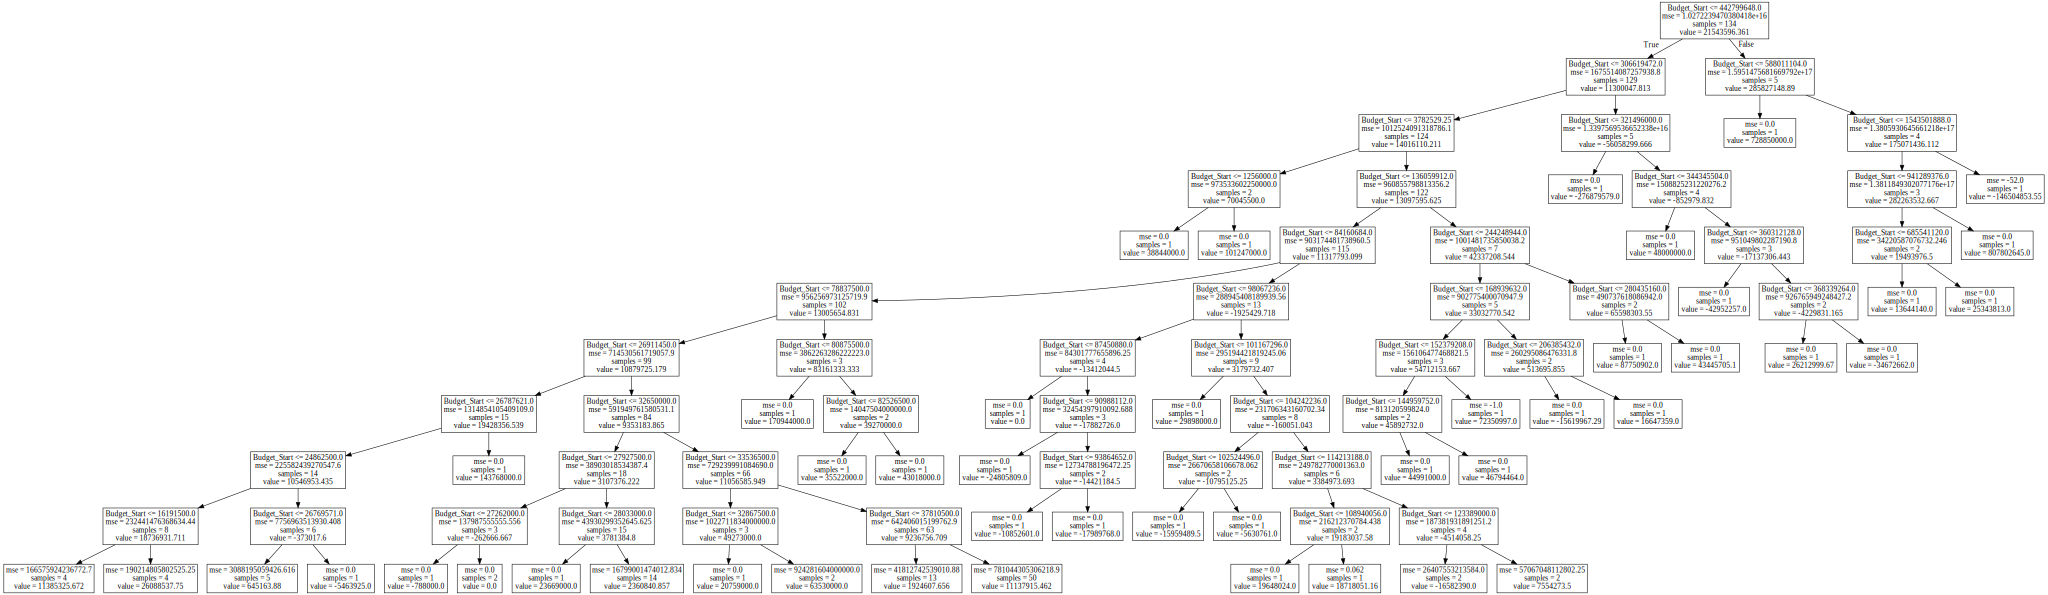

In [54]:
idx = results_df.best_depth.idxmax()
print(f"Index Chosen: {idx}")

m_dict = results_df.iloc[idx]
print(f"Best CV Score of Model Chosen: {m_dict.get('best_cv_score')} // Depth: {m_dict.get('best_depth')}")
print(f"Corresponding Train R2 Score: {round(m_dict.get('train_score'),4)}")
print(f"Corresponding Test R2 Score: {round(m_dict.get('test_score'),4)}")

xtree = m_dict.best_model

if len(m_dict.dummies_dict) == 0:
    tree_dot_data = tree.export_graphviz(xtree, feature_names=m_dict.attributes)
else:
    tree_dot_data = tree.export_graphviz(xtree, feature_names=list(set(m_dict.attributes) - set(m_dict.dummies_dict.keys())) + m_dict.dummies_dict.get('Category'))
    
gr = graphviz.Source(tree_dot_data)
display(gr)

## Review Best Performing Model

Index Chosen: 11
Best CV Score of Model Chosen: 0.45 // Depth: 5
Corresponding Train R2 Score: 0.441
Corresponding Test R2 Score: 0.4453


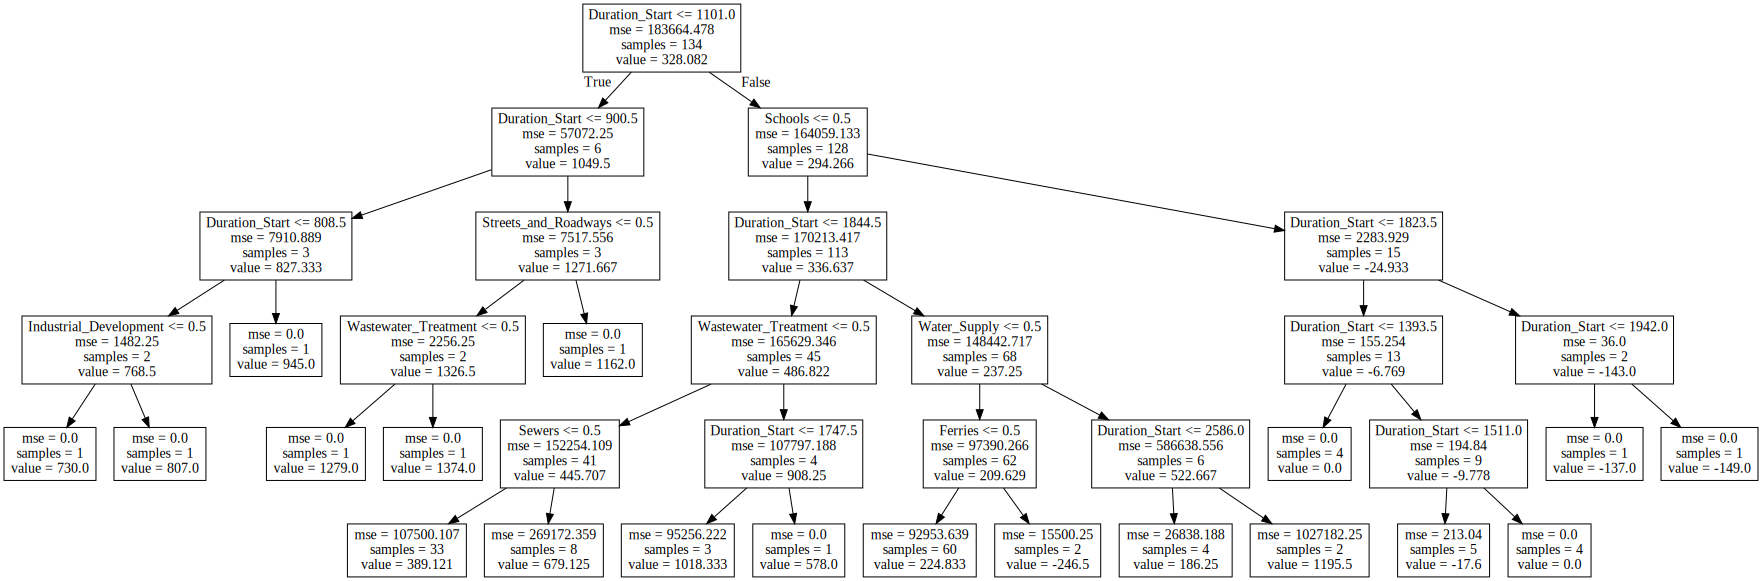

In [55]:
idx = results_df.best_cv_score.idxmax()
print(f"Index Chosen: {idx}")

m_dict = results_df.iloc[idx]
print(f"Best CV Score of Model Chosen: {m_dict.get('best_cv_score')} // Depth: {m_dict.get('best_depth')}")
print(f"Corresponding Train R2 Score: {round(m_dict.get('train_score'),4)}")
print(f"Corresponding Test R2 Score: {round(m_dict.get('test_score'),4)}")

xtree = m_dict.best_model

if len(m_dict.dummies_dict) == 0:
    tree_dot_data = tree.export_graphviz(xtree, feature_names=m_dict.attributes)
else:
    tree_dot_data = tree.export_graphviz(xtree, feature_names=list(set(m_dict.attributes) - set(m_dict.dummies_dict.keys())) + m_dict.dummies_dict.get('Category'))
    
gr = graphviz.Source(tree_dot_data)
display(gr)

## ADABoosting
Use the best performing depth and features Regressor model in an ADABoost model

In [56]:
# get parameters from best Regressor Model
idx = results_df.best_cv_score.idxmax()
m_dict = results_df.iloc[idx]
dummy_cols = list(m_dict.dummies_dict.keys())
attributes = m_dict.dummies_dict.get('Category') + ['Duration_Start']
X_tr, X_te, y_tr, y_te, dummies_dict = define_train_and_test(data, dummy_cols, m_dict.attributes, ['Budget_Change', 'Schedule_Change'], logistic=False) 

model_descr = 'AdaBoost tree ensemble unscaled data'

# set parameters for AdaBoostRegressor model object
max_depth = m_dict.best_depth
learning_rate = 0.05
n_estimators = 100
random_state = 109

model_ada_unscaled = generate_model_dict(
    AdaBoostRegressor,
    model_descr,
    X_tr[attributes], X_te[attributes], y_tr, y_te,
    multioutput=False,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn',
    # these parameters below will be passed as *kwargs,
    # which means they will feed directly to the model object
    # when it is initialized
    base_estimator=DecisionTreeRegressor(
        max_depth=max_depth, random_state=random_state
    ),
    learning_rate = learning_rate,
    n_estimators = n_estimators,
    random_state=random_state
)

print_model_results(model_ada_unscaled)


MODEL SUMMARY:
AdaBoost tree ensemble unscaled data


The fitted model object(s):

	AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=5,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=109,
       